## <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Cholesterol: Unveiling Key Indicators</p>



In [36]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

#Modeling
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedKFold
import lightgbm as lgbm
from yellowbrick.cluster import KElbowVisualizer
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
#from sklego.linear_model import LADRegression
from xgboost import XGBRegressor
from scipy.stats import yeojohnson
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from mlxtend.regressor import StackingCVRegressor
from sklearn.preprocessing import PolynomialFeatures
import optuna
from scipy.stats import pearsonr

pio.templates.default = "none"

import warnings
warnings.filterwarnings('ignore')

palette  = ['#6499E9', '#9EDDFF', '#A6F6FF', '#BEFFF7']


# **Introduction** <a class="anchor" id="0"></a>
<div style="text-align:center;">
    <img src="https://raw.githubusercontent.com/juanvalno/itb/51bc8c11d66fbb2c905d2220f0473cc622e01de8/Image/kolesterol.jpg" alt="Alternative text" />
</div>

Selain memenuhi kebutuhan fisik dasar, kesehatan merupakan salah satu faktor yang berkontribusi terhadap vitalitas dan kualitas hidup secara keseluruhan. Seiring dengan kemajuan masyarakat, memahami faktor-faktor rumit yang mempengaruhi hasil kesehatan menjadi hal yang sangat penting dalam merancang strategi efektif untuk meningkatkan dan mempertahankan kesejahteraan.

Salah satu indikator kunci kesehatan adalah kadar kolesterol darah, khususnya kolesterol total (CT). Peningkatan CT sangat terkait dengan peningkatan risiko penyakit kardiovaskular, yang merupakan penyebab utama kematian di seluruh dunia. Mengidentifikasi faktor kesehatan spesifik yang mempengaruhi tingkat CT dapat memberikan wawasan penting untuk memandu intervensi kesehatan masyarakat dan praktik klinis.

Sejalan dengan contoh yang diberikan, di mana pendidikan merupakan faktor penentu prospek anak-anak, upaya kami untuk menyelidiki faktor-faktor yang mempengaruhi tingkat CT menggarisbawahi pentingnya langkah-langkah proaktif dalam menjaga hasil kesehatan individu. Namun, ketika pandemi COVID-19 mengganggu sistem pendidikan secara global, bidang kesehatan juga menghadapi tantangan yang memerlukan metodologi yang kuat dan pendekatan interdisipliner untuk mengatasi permasalahan kesehatan yang terus berkembang.

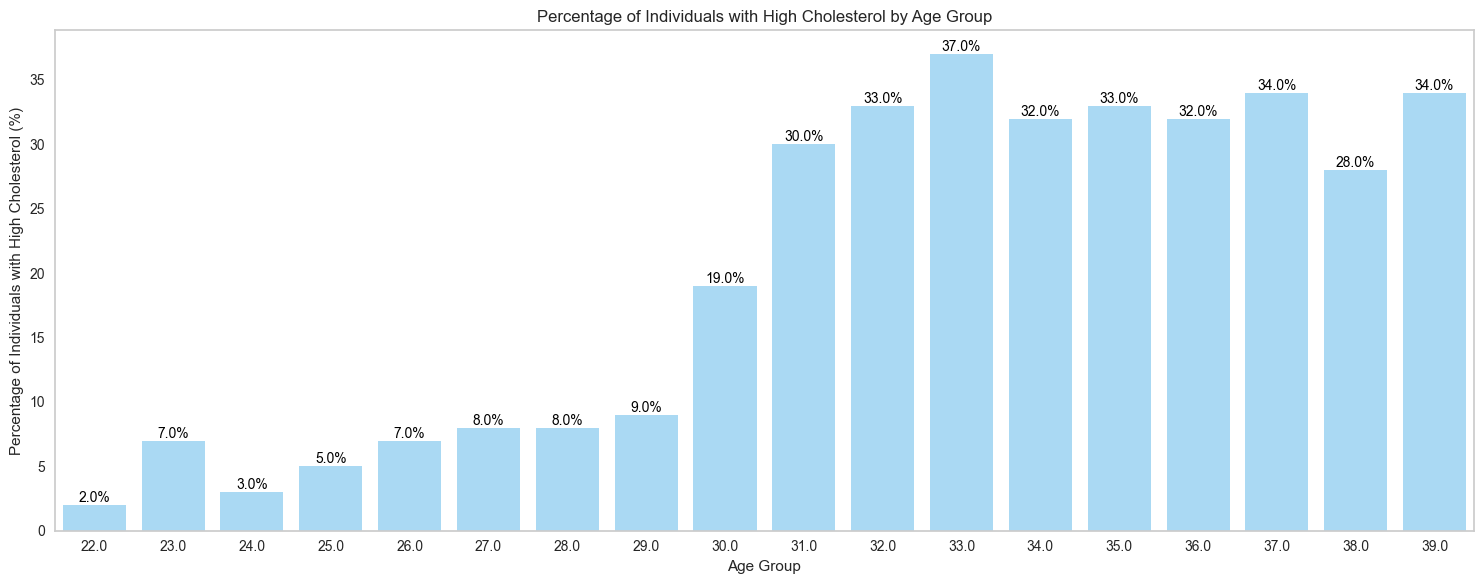

In [37]:
df = pd.read_csv('Data_2.csv')
x = df.copy()
age_groups = x.groupby('Usia')

counts_high_cholesterol = age_groups.apply(lambda group: (group['Cholesterol Total (mg/dL)'] >= 200).sum())
total_counts = age_groups.size()  
percentages = round((counts_high_cholesterol / total_counts) * 100)

x['Percentage_High_Cholesterol'] = x['Usia'].map(percentages)

mask = x[x['Cholesterol Total (mg/dL)'] >= 200].reset_index(drop=True)
a = mask[['Jenis Kelamin',	'Usia', 'Percentage_High_Cholesterol']].drop_duplicates()

a.Usia = a.Usia.astype('object')

plt.figure(figsize=(15,6))
ax = sns.barplot( x=a['Usia'], y=a['Percentage_High_Cholesterol'], color='lightsalmon', palette=[palette[1]])
ax.grid(False)
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('Percentage of Individuals with High Cholesterol by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Percentage of Individuals with High Cholesterol (%)')

plt.tight_layout()
plt.show()

Penting untuk menyadari pentingnya peningkatan kadar kolesterol di kalangan generasi muda. Meskipun secara tradisional penyakit ini dikaitkan dengan kelompok usia yang lebih tua, peningkatan prevalensi kolesterol tinggi di kalangan generasi muda menggarisbawahi pentingnya mengatasi masalah ini sejak dini untuk memitigasi risiko kesehatan jangka panjang dan mendorong gaya hidup yang lebih sehat.

<blockquote style="margin-right:auto; margin-left:auto; color:white; background-color:#4e4e4e; padding: 1em; margin:24px;">

<font color="white" size=+1.0><b>Some facts according to Verywell Health</b></font>  
        
<ul>
<li> Hal ini diukur dengan membandingkannya dengan hasil HDL individu Anda untuk mengukur risiko penyakit jantung dan stroke. 
<li> Diperkirakan 2,6 juta kematian (4,5% dari total) dan 29,7 juta DALYs (2% dari total) disebabkan oleh peningkatan kolesterol. (DALY: Disability-Adjusted Life Years -satuan untuk mengukur beban penyakit)
<li> HDL (kolesterol baik) membantu menghilangkan kolesterol dari arteri, sementara LDL (kolesterol jahat) dapat menumpuk di arteri dan menyebabkan penyumbatan.
<li> Total cholesterol is measured using a blood test called a lipoprotein panel, which also includes triglycerides.
<li> Skor kolesterol total dihitung sebagai: kadar HDL + kadar LDL + 20% dari kadar trigliserida.
<li> Dengan skrining rutin dan intervensi dini, risiko komplikasi akibat kolesterol tinggi dapat diminimalkan.                                                                                                                                
    
</ul>        
</blockquote>

#### **Objectives**
This notebook has two main objectives:
* Explore the cholesterol dataset using exploratory data analysis (EDA)
* Exercise with regression algorithms for prediction (modelling) 









##  **Dataset and Setup** <a class="anchor" id="1"></a>

Untuk kompetisi ini kami diberikan dataset dari MCF-ITB. Kumpulan data sebagian besar berisi data kesehatan dengan total 1339 baris dan total 16 fitur.

### **Dataset Dictionary**
1. Jenis Kelamin
    * 1 = Pria
    * 0 = Wanita
2. Usia: Usia (Tahun)
3. Tekanan Darah (S): tekanan darah pada saat jantung berkontraksi
4. Tekanan Darah (D) : tekanan darah pada saat jantung beristirahat
5. Tinggi Badan (cm)
6. Berat Badan (kg)
7. IMT (kg/m2): Indeks Massa Tubuh
    * kurang dari 18,5 : Kurus
    * 18,5-24,9: Normal
    * 25-29,9: Kegemukan
    * 30 atau lebih :Obesitas
8. Lingkar perut (cm): ukuran lingkar dari area di sekitar pinggang
9. Glukosa Puasa (mg/dL): kadar glukosa dalam darah setelah seseorang puasa selama minimal 8 jam
10. Trigliserida (mg/dL): kadar lemak dalam darah
10. Fat: jumlah total lemak tubuh 
11. Visceral Fat: jumlah lemak tubuh yang terletak di sekitar organ dalam tubuh, seperti hati, pankreas, dan usus
12. Masa Kerja: jumlah waktu yang telah dihabiskan seseorang dalam bekerja
13. Tempat Lahir: tempat dilahirkan
14. Cholesterol Total: Cholesterol total dalam satuan (mg/dL)
---    

In [38]:
df = pd.read_csv('Data_2.csv')
df.tail()

,Responden,Jenis Kelamin,Usia,Tekanan darah (S),Tekanan darah (D),Tinggi badan (cm),Berat badan (kg),IMT (kg/m2),Lingkar perut (cm),Glukosa Puasa (mg/dL),Cholesterol Total (mg/dL),Trigliserida (mg/dL),Fat,Visceral Fat,Masa Kerja,Tempat lahir
1334,1335,M,39.0,110.0,70.0,162.5,67.60,25.60,87.0,84.0,169.0,72.0,23.8,11.0,6.00,Bogor
1335,1336,F,39.0,120.0,70.0,150.0,60.50,26.90,77.0,84.0,199.0,105.0,38.1,9.0,6.15,Bogor
1336,1337,F,39.0,120.0,80.0,151.0,59.75,26.20,78.0,84.0,177.0,78.0,35.3,8.0,26.00,Bogor
1337,1338,M,39.0,110.0,70.0,166.2,57.00,20.63,69.0,84.0,244.0,98.0,17.1,5.0,4.30,Bogor
1338,1339,F,39.0,110.0,70.0,155.0,52.15,21.70,70.0,84.0,180.0,51.0,26.4,6.0,5.49,Tasikmalaya


In [39]:
nan_count = df.isnull().sum().reset_index(name='nan')
data_types = df.dtypes.reset_index(name='dtype')

result = pd.merge(nan_count, data_types, on='index')
result

,index,nan,dtype
0,Responden,0,int64
1,Jenis Kelamin,0,object
2,Usia,0,float64
3,Tekanan darah (S),0,float64
4,Tekanan darah (D),0,float64
5,Tinggi badan (cm),0,float64
6,Berat badan (kg),0,float64
7,IMT (kg/m2),0,float64
8,Lingkar perut (cm),0,float64
9,Glukosa Puasa (mg/dL),0,float64


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1339 entries, 0 to 1338
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Responden                  1339 non-null   int64  
 1   Jenis Kelamin              1339 non-null   object 
 2   Usia                       1339 non-null   float64
 3   Tekanan darah  (S)         1339 non-null   float64
 4   Tekanan darah  (D)         1339 non-null   float64
 5   Tinggi badan (cm)          1339 non-null   float64
 6   Berat badan (kg)           1339 non-null   float64
 7   IMT (kg/m2)                1339 non-null   float64
 8   Lingkar perut (cm)         1339 non-null   float64
 9   Glukosa Puasa (mg/dL)      1339 non-null   float64
 10  Cholesterol Total (mg/dL)  1339 non-null   float64
 11  Trigliserida (mg/dL)       1339 non-null   float64
 12  Fat                        1339 non-null   float64
 13  Visceral Fat               1339 non-null   float


# 1. **Exploratory Data Analysis** <a class="anchor" id="2"></a>
Dalam analisis data eksplorasi (EDA) ini, kami bertujuan untuk mempelajari kumpulan data dan mendapatkan wawasan tentang berbagai parameter terkait kesehatan. Dengan memeriksa distribusi, hubungan, dan korelasi dalam data, kita dapat mengungkap informasi berharga yang dapat menjadi bahan analisis lebih lanjut dan memperoleh wawasan berharga mengenai faktor-faktor penentu kadar kolesterol dan implikasinya terhadap hasil kesehatan.

In [41]:
num_cols = [col for col in df.columns if df[col].dtype != 'object'][1:]
num_cols.remove('Cholesterol Total (mg/dL)')

df['Tinggi_badan (m)'] = df['Tinggi badan (cm)'] / 100
df['IMT'] = df['Berat badan (kg)'] / (df['Tinggi_badan (m)'] * df['Tinggi_badan (m)'])
df['IMT_gap'] = df['IMT'] - df['IMT (kg/m2)']
imt_gap = df[df['IMT_gap'] != 0]

imt_gap

,Responden,Jenis Kelamin,Usia,Tekanan darah (S),Tekanan darah (D),Tinggi badan (cm),Berat badan (kg),IMT (kg/m2),Lingkar perut (cm),Glukosa Puasa (mg/dL),Cholesterol Total (mg/dL),Trigliserida (mg/dL),Fat,Visceral Fat,Masa Kerja,Tempat lahir,Tinggi_badan (m),IMT,IMT_gap
0,1,M,19.0,126.0,88.0,172.5,49.50,16.53,66.0,84.0,187.0,99.0,26.4,6.0,0.97,Purworejo,1.725,16.635161,1.051607e-01
1,2,M,19.0,120.0,80.0,158.0,53.60,21.50,71.0,84.0,187.0,99.0,26.4,6.0,0.60,Bogor,1.580,21.470918,-2.908188e-02
2,3,M,19.0,120.0,80.0,170.0,59.50,20.59,80.0,80.0,187.0,99.0,26.4,6.0,1.37,bandung,1.700,20.588235,-1.764706e-03
3,4,F,19.0,100.0,70.0,149.0,45.10,20.31,62.0,81.0,187.0,99.0,30.5,3.5,1.00,Jakarta,1.490,20.314400,4.400252e-03
4,5,M,19.0,110.0,70.0,171.6,62.40,21.19,78.0,84.0,187.0,99.0,26.4,6.0,4.00,Teluk Betung,1.716,21.190930,9.302818e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1334,1335,M,39.0,110.0,70.0,162.5,67.60,25.60,87.0,84.0,169.0,72.0,23.8,11.0,6.00,Bogor,1.625,25.600000,-3.552714e-15
1335,1336,F,39.0,120.0,70.0,150.0,60.50,26.90,77.0,84.0,199.0,105.0,38.1,9.0,6.15,Bogor,1.500,26.888889,-1.111111e-02
1336,1337,F,39.0,120.0,80.0,151.0,59.75,26.20,78.0,84.0,177.0,78.0,35.3,8.0,26.00,Bogor,1.510,26.204991,4.991009e-03
1337,1338,M,39.0,110.0,70.0,166.2,57.00,20.63,69.0,84.0,244.0,98.0,17.1,5.0,4.30,Bogor,1.662,20.635396,5.396439e-03


In [42]:

new_col_names = {
    'Tekanan darah  (S)': 'Tekanan_darah_(S)',
    'Tekanan darah  (D)': 'Tekanan_darah_(D)',
    'Tinggi badan (cm)': 'Tinggi_badan_(cm)',
    'Berat badan (kg)': 'Berat_badan_(kg)',
    'IMT (kg/m2)': 'IMT_(kg/m2)',
    'Lingkar perut (cm)': 'Lingkar_perut_(cm)',
    'Glukosa Puasa (mg/dL)': 'Glukosa_Puasa_(mg/dL)',
    'Cholesterol Total (mg/dL)': 'Cholesterol_Total_(mg/dL)',
    'Trigliserida (mg/dL)': 'Trigliserida_(mg/dL)',
    'Jenis Kelamin':'Jenis_Kelamin',
    'Visceral Fat':'Visceral_Fat',
    'Masa Kerja':'Masa_Kerja',
    'Tempat lahir':'Tempat_lahir'
}

df = df.rename(columns=new_col_names)
    

## 1.1 **Exploring Target and Statistical Summary** <a class="anchor" id="1.1"></a>

Pada section ini kita akan mengetahui distribusi dari label cholesterol total juga akan melihat statistical summary bila memungkinkan dan distribusi diantara features lainnya

#### 1.1.1 Target distribution
 
Target distribution dapat dilihat jika target tidaklah mengikuti normal distribution dikarenakan adanya skewed di nilai 187, maka kita dapat meminimalisir ini dengan cara log transformation sebelum masuk ke modeling phase.

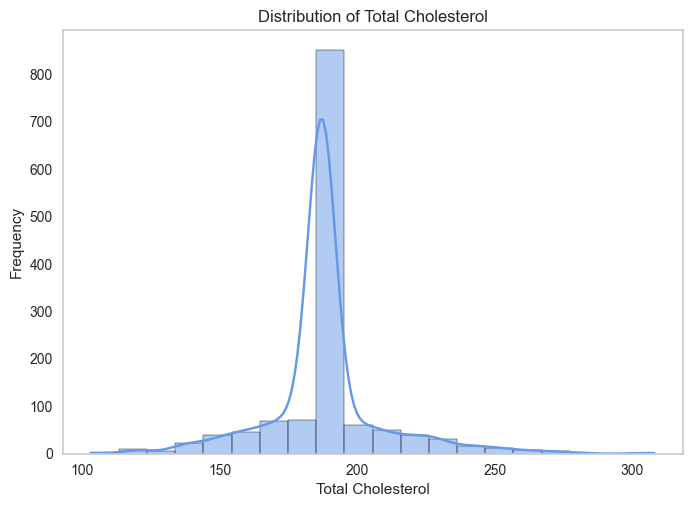

In [43]:
ax = sns.histplot(data=df, x='Cholesterol_Total_(mg/dL)', bins=20, color='#6499E9', kde=True)

plt.xlabel('Total Cholesterol')
plt.ylabel('Frequency')
plt.title('Distribution of Total Cholesterol')
ax.grid(False)

plt.show()

#### 1.1.2 Numerical Features

##### Statistical summary
Untuk fitur numerik kita dapat menerapkan metode `data.describe()` untuk mendapatkan ringkasan statistik global.

In [44]:
num_cols = [col for col in df.columns if df[col].dtype != 'object'][1:]
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Usia,1339.0,28.597461,4.767230,19.000000,25.000000,28.000000,31.000000,39.000000
Tekanan_darah_(S),1339.0,113.147872,10.164592,80.000000,110.000000,110.000000,120.000000,170.000000
Tekanan_darah_(D),1339.0,74.009709,7.718752,58.000000,70.000000,72.000000,80.000000,100.000000
Tinggi_badan_(cm),1339.0,164.940851,7.386617,138.500000,160.000000,165.000000,170.000000,187.500000
Berat_badan_(kg),1339.0,64.620500,12.799096,38.500000,55.275000,62.500000,71.775000,139.750000
IMT_(kg/m2),1339.0,23.693727,4.021585,14.850000,20.855000,23.200000,26.000000,44.100000
Lingkar_perut_(cm),1339.0,80.441972,10.688215,54.000000,72.000000,80.000000,87.000000,128.000000
Glukosa_Puasa_(mg/dL),1339.0,84.571322,11.522057,65.000000,84.000000,84.000000,84.000000,321.000000
Cholesterol_Total_(mg/dL),1339.0,187.995519,21.104834,103.000000,187.000000,187.000000,187.000000,308.000000
Trigliserida_(mg/dL),1339.0,106.982823,44.143456,34.000000,99.000000,99.000000,99.000000,634.000000


#### **Statistical summary of the numerical features**

<blockquote style="margin-right:auto; margin-left:auto; color:white; background-color: #4e4e4e; padding: 1em; margin:24px;">
<ul>
<li> <font color="white" size=+1.0><b>Usia</b></font> :
    <ul>
    <li> Rata-rata usia responden adalah 29 Tahun
    <li> Responden tertua berusia 39 Tahun, sementara responden termuda berusia 19 Tahun
    </ul>
<li> <font color="white" size=+1.0><b>Tekanan Darah (S) </b></font>
    <ul>
    <li> Rata-Rata Tekanan Darah Sistolik Responden adalah 113 mmHg
    <li> Tekanan darah sistolik tertinggi adalah 170 mmHg, sementara terendah 80 mmHg
    <li> <strong>Note</strong>: According to [4], Tekanan Darah sistolik ada beberapa indikator
Untuk Orang dewasa (18 tahun ke atas):

Normal: < 120 mmHg
             
Pre-hipertensi: 120-129 mmHg
             
Hipertensi stadium 1: 130-139 mmHg
             
Hipertensi stadium 2: ≥ 140 mmHg
             
Lansia (65 tahun ke atas):

Normal: < 130 mmHg
        
Pre-hipertensi: 130-139 mmHg
        
Hipertensi stadium 1: 140-159 mmHg
        
Hipertensi stadium 2: ≥ 160 mmHg     
    </ul>
<li> <font color="white" size=+1.0><b>Tekanan Darah Diastolik:</b></font>
    <ul>
    <li> Rata-Rata Tekanan Darah Diastolik Responden adalah 74 mmHg
    <li> Tekanan darah diastolik tertinggi adalah 100 mmHg, sementara terendah 58 mmHg
    <li> <strong>Note</strong>: According to [4], Tekanan Darah diastolik ada beberapa indikator:

Normal: < 80 mmHg
            
Pre-hipertensi: 80-84 mmHg
            
Hipertensi stadium 1: 85-89 mmHg
            
Hipertensi stadium 2: ≥ 90 mmHg 
    </ul>
<li> <font color="white" size=+1.0><b>Tinggi Badan:</b></font>
    <ul>
    <li> Rata-rata tinggi badan responden adalah 164 cm. Tinggi badan tertinggi adalah 187,5 cm, sementara terendah 138,5 cm
    </ul>
<li> <font color="white" size=+1.0><b>Berat Badan</b></font>
    <ul>
    <li> Rata-rata berat badan responden adalah 65 kg. Berat badan tertinggi adalah 139,75 kg, sementara terendah 55 kg
    </ul>
<li> <font color="white" size=+1.0><b>IMT</b></font>
    <ul>
    <li> Rata-rata IMT responden adalah 23,69 kg/m2. IMT tertinggi adalah 44,1 kg/m2, sementara terendah 14,85 kg/m2
    </ul>
<li> <font color="white" size=+1.0><b>Lingkar Perut</b></font>
    <ul>
    <li> Rata-rata lingkar perut responden adalah 80 cm. Lingkar perut terbesar adalah 128 cm, sementara terkecil 54 cm
    </ul>
<li> <font color="white" size=+1.0><b>Glukosa Puasa</b></font>
    <ul>
    <li> Rata-rata Glukosa Puasa Responden adalah 85 mg/dL. Glukosa puasa tertinggi 321 mg/dL, sementara terendah 65 mg/dL
<li> <strong>Note</strong>: According to [5], Glukosa gula darah yang baik itu berada di $<100 mg/dl$
    </ul>
<li> <font color="white" size=+1.0><b>Trigliserida (mg/dL)</b></font>
    <ul>
    <li> Rata-rata trigliserida responden adalah 107 mg/dL, Trigliserida tertinggi 321 mg/dL, sementara terendah 34 mg/dL
<li> <strong>Note</strong>: According to [6], Trigliserida yang baik itu berada di $<150 mg/dl$
    </ul>
<li> <font color="white" size=+1.0><b>Fat</b></font>
    <ul>
    <li> Rata-rata lemak tubuh responden adalah 26%, paling rendah adalah 5.8% dan paling tinggi adalah 141%.
<li> <strong>Note</strong>: According to [7], kadar normal lemak 25-31 persen tubuh untuk wanita, dan 18-25 persen tubuh untuk pria.
    </ul>
<li> <font color="white" size=+1.0><b>Visceral Fat</b></font>
    <ul>
    <li> Rata-rata lemak tubuh responden adalah 26%, paling rendah adalah 5.8% dan paling tinggi adalah 141%.
<li> <strong>Note</strong>: According to [8], Ratio normal visceral fat bagi pria adalah kurang dari 0.9 dan wanita kurang dari 0.84.
    </ul>
<li> <font color="white" size=+1.0><b>Masa Kerja</b></font>
    <ul>
    <li> Rata-rata masa kerja responden adalah 6 tahun, paling baru tidak sampai 1 tahun dan paling lama adalah 31 tahun
    </ul>
</ul>                                                                                                                                             
</blockquote>



In [45]:
df.describe(include=['object'])

,Jenis_Kelamin,Tempat_lahir
count,1339,1339
unique,2,170
top,M,Bogor
freq,1013,352


## 1.2 **Distribution Features** <a class="anchor" id="1.1"></a>


In [46]:
df['Cholesterol_Total_Map'] = np.where(df['Cholesterol_Total_(mg/dL)'] > 200, 'Tinggi', 'Rendah')
num_cols.append('Cholesterol_Total_Map')

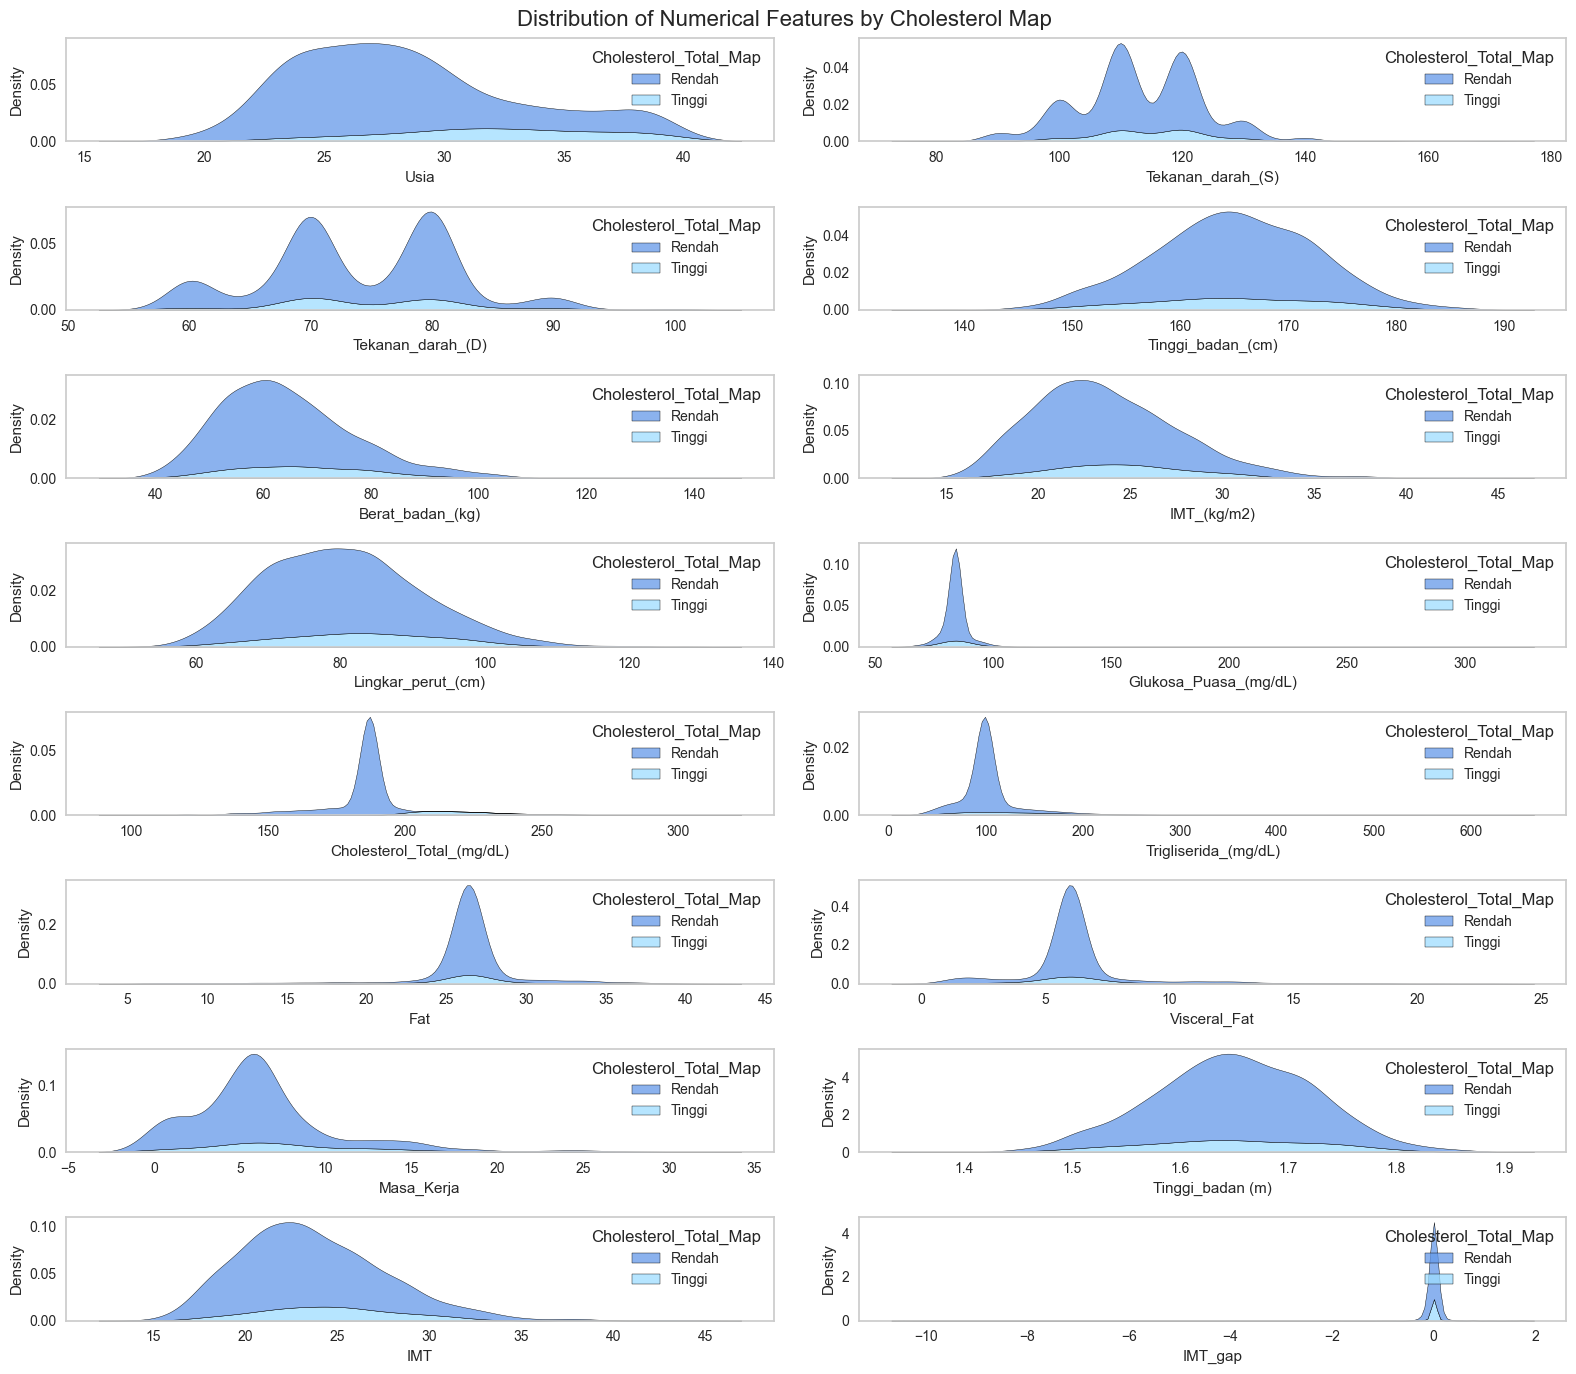

In [47]:
ncol=2
nrow = (len(num_cols) - 2) // ncol + ((len(num_cols) - 2) % ncol > 0) 

fig, ax = plt.subplots(nrow, ncol, figsize=(16, 14))   
fig.subplots_adjust(top=0.95)

i = 0 
for col in num_cols[:-1]: 
    ax_curr = ax[i // ncol, i % ncol]  
    plt.subplot(nrow, ncol, i+1)  
    sns.kdeplot(data=df, x=col, hue="Cholesterol_Total_Map", multiple="stack", palette=palette)
    ax_curr.grid(False)
    i += 1
plt.suptitle('Distribution of Numerical Features by Cholesterol Map' ,fontsize = 16)
plt.tight_layout()
plt.show()

In [48]:
imt_categories = {
    'Underweight': (0, 17.0),
    'Normal': (17.0, 25.0),
    'Overweight': (25.1, 27.0),
    'Obese': (27.1, np.inf)
}

def map_imt_category(imt):
    for category, (lower, upper) in imt_categories.items():
        if lower <= imt <= upper:
            return category
    return None  

df['IMT_Category'] = df['IMT_(kg/m2)'].apply(map_imt_category)

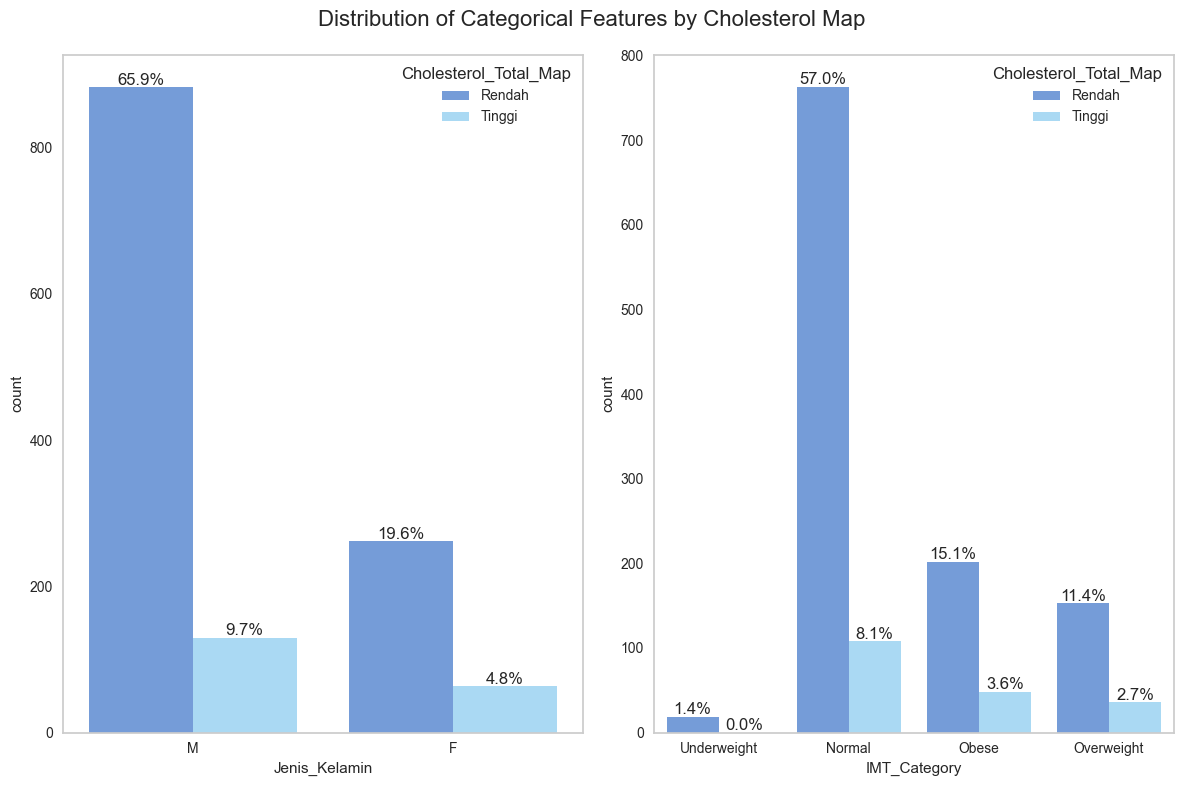

In [49]:
def annotate_percentage(plot, total_count):
    for p in plot.patches:
        height = p.get_height()
        plot.text(p.get_x() + p.get_width() / 2., height + 3, '{:.1f}%'.format((height / total_count) * 100), ha='center')

fig, ax = plt.subplots(1, 2, figsize=(12, 8))


palette = ['#6499E9', '#9EDDFF', '#A6F6FF', '#BEFFF7']
total_count_gender = len(df['Jenis_Kelamin'])
total_count_imt = len(df['IMT_Category'])

sns.countplot(x=df['Jenis_Kelamin'], ax=ax[0], hue=df['Cholesterol_Total_Map'], palette=palette)
sns.countplot(x=df['IMT_Category'], ax=ax[1], hue=df['Cholesterol_Total_Map'], palette=palette)

# Annotate countplots with percentage values
annotate_percentage(ax[0], total_count_gender)
annotate_percentage(ax[1], total_count_imt)

# Remove grid lines
ax[0].grid(False)
ax[1].grid(False)

# Add title and adjust layout
plt.suptitle('Distribution of Categorical Features by Cholesterol Map', fontsize=16)
plt.tight_layout()
plt.show()


In [50]:
mask = df['Tempat_lahir'].value_counts().reset_index(name='count').sort_values('count', ascending=False)
total_count = mask['count'].sum()
mask['percentage'] = round((mask['count'] / total_count) * 100)
mask = mask.head(10)

fig = go.Figure()
fig.add_trace(
    go.Pie(
        labels=mask['Tempat_lahir'],
        title="Top 10 Frequent of Tempat lahir",
                  titlefont={'size':18, 'family': 'Serif',},
         values=mask['count'],
        hole=0.5,
        )
    )
fig.update_traces(
    hoverinfo='label+value',
    textinfo='label+percent',
    textfont_size=12,
    )
fig.layout.update(title="<b>Count of Tempat Lahir<b>",
                  titlefont={'size':24, 'family': 'Serif',},
                  showlegend=False, 
                  height=700, 
                  width=700, 
                  template=None, 
                 )

fig.show()

Distribution baik dari categorical features menggunakan count plot untuk mendapat jumlah distribusi dari setiap kategori. Setiap categorical dan numerical distribusi dari tiap kategori dalam dataset dan kontribusinya terhadap probabilitas prediksi dari variabel target, yaitu memiliki kolesterol tinggi atau normal.

<blockquote style="margin-right:auto; margin-left:auto; color:white; background-color: #4e4e4e; padding: 1em; margin:24px;">
   
<ul>
<li> <font color="white" size=+1.0><b>Jenis Kelamin:</b></font>
    <ul>
        <li> Pria memiliki <strong>persentase kolesterol normal lebih tinggi (65.9%) </strong> dibandingkan wanita hanya dengan (19.6%). 
        <li> Pria juga memiliki <strong>persentase kolesterol tinggi lebih tinggi sebesar (9.7%) </strong> dibandingkan wanita (4.8%). Secara jumlah pria (133) memiliki jumlah kolesterol lebih banyak daripada wanita (65).       

    
</ul>                                                                                                                                             
</blockquote>

<blockquote style="margin-right:auto; margin-left:auto; color:white; background-color: #4e4e4e; padding: 1em; margin:24px;">
   
<ul>
<li> <font color="white" size=+1.0><b>IMT:</b></font>
    <ul>
        <li> Orang dengan IMT kurang dari 17 memiliki <strong>risiko kolesterol tinggi paling rendah</strong>.
        <li> Orang dengan IMT normal (17.0 - 25.0) memiliki <strong>persentase kolesterol tinggi tertinggi sebesar 8.1%</strong>, ini mungkin terjadi karena responden dengan IMT normal lebih banyak muncul di data.
        <li> Orang dengan IMT di atas normal (25.1 - 27.0) memiliki risiko kolesterol tinggi yang lebih tinggi.
        <li> Orang dengan IMT obesitas (> 27.0) memiliki risiko kolesterol tinggi yang paling tinggi. Ini disebabkan oleh peningkatan produksi kolesterol LDL dan trigliserida yang disebabkan oleh lemak berlebih di tubuh.
    </ul>
</ul>
</blockquote>


## 1.3 **Bivariate Analysis** <a class="anchor" id="1.1"></a>
Analisis bivariat ini bertujuan untuk mengeksplorasi hubungan antara dua variabel. Dalam konteks ini, kita akan mengekplorasi antara dua features untuk mendapat pemahaman yang lebih mendalam.

#### 1.3.1 Significant Difference in Blood Pressure between Genders

Analisis tekanan darah telah mengungkapkan beberapa perbedaan penting berdasarkan gender yang memberikan wawasan berharga. Melalui penggunaan uji Mann-Whitney U, sebuah teknik statistik untuk membandingkan distribusi dua kelompok independen, penelitian ini menemukan perbedaan yang signifikan secara statistik pada tekanan darah sistolik dan diastolik antara partisipan pria dan wanita. Metode tersebut dipilih karena tekanan darah sistolik dan diastolik tidak mengikuti distribusi normal.

In [51]:
from scipy.stats import mannwhitneyu

systolic_male = df[df['Jenis_Kelamin'] == 'M']['Tekanan_darah_(S)']
systolic_female = df[df['Jenis_Kelamin'] == 'F']['Tekanan_darah_(S)']

diastolic_male = df[df['Jenis_Kelamin'] == 'M']['Tekanan_darah_(D)']
diastolic_female = df[df['Jenis_Kelamin'] == 'F']['Tekanan_darah_(D)']

# Perform Mann-Whitney U test for systolic blood pressure
statistic_systolic, pvalue_systolic = mannwhitneyu(systolic_male, systolic_female)

# Perform Mann-Whitney U test for diastolic blood pressure
statistic_diastolic, pvalue_diastolic = mannwhitneyu(diastolic_male, diastolic_female)

print("Mann-Whitney U Test Results for Systolic Blood Pressure:")
print("Statistic:", statistic_systolic)
print("P-value:", pvalue_systolic)

print("\nMann-Whitney U Test Results for Diastolic Blood Pressure:")
print("Statistic:", statistic_diastolic)
print("P-value:", pvalue_diastolic)

if (pvalue_systolic < 0.05) or (pvalue_diastolic < 0.05):
    print("\nThere is a significant difference in blood pressure wether Systolic Blood or Diastolic Blood between males and females.")
else:
    print("\nThere is no significant difference in blood pressure between males and females.")


Mann-Whitney U Test Results for Systolic Blood Pressure:
Statistic: 197733.5
P-value: 3.227204320549423e-08

Mann-Whitney U Test Results for Diastolic Blood Pressure:
Statistic: 203467.0
P-value: 6.356233848851536e-11

There is a significant difference in blood pressure wether Systolic Blood or Diastolic Blood between males and females.


Kita dapat melihat bahwa perbedaan tekanan darah yang diamati antara pria dan wanita tidak terjadi secara kebetulan – perbedaan tersebut memang benar dan bermakna. Meskipun analisis tidak secara eksplisit menyatakan arah perbedaan ini, berdasarkan pemahaman umum kita tentang fisiologi kardiovaskular, peserta laki-laki kemungkinan besar memiliki nilai tekanan darah sistolik dan diastolik yang lebih tinggi dibandingkan peserta perempuan.

Saat menilai dan menangani hipertensi atau kondisi terkait tekanan darah lainnya, penting untuk mempertimbangkan perbedaan spesifik gender. Strategi skrining, pencegahan, dan pengobatan yang disesuaikan mungkin diperlukan untuk secara efektif mengatasi profil tekanan darah unik pada pria dan wanita.

Selain itu, perbedaan tekanan darah antar gender juga dapat berinteraksi dan memengaruhi faktor risiko kardiovaskular lainnya, seperti kadar kolesterol. Langkah logis berikutnya adalah mengeksplorasi bagaimana perbedaan tekanan darah antara pria dan wanita mungkin berhubungan dan berdampak pada kolesterol total (CT).

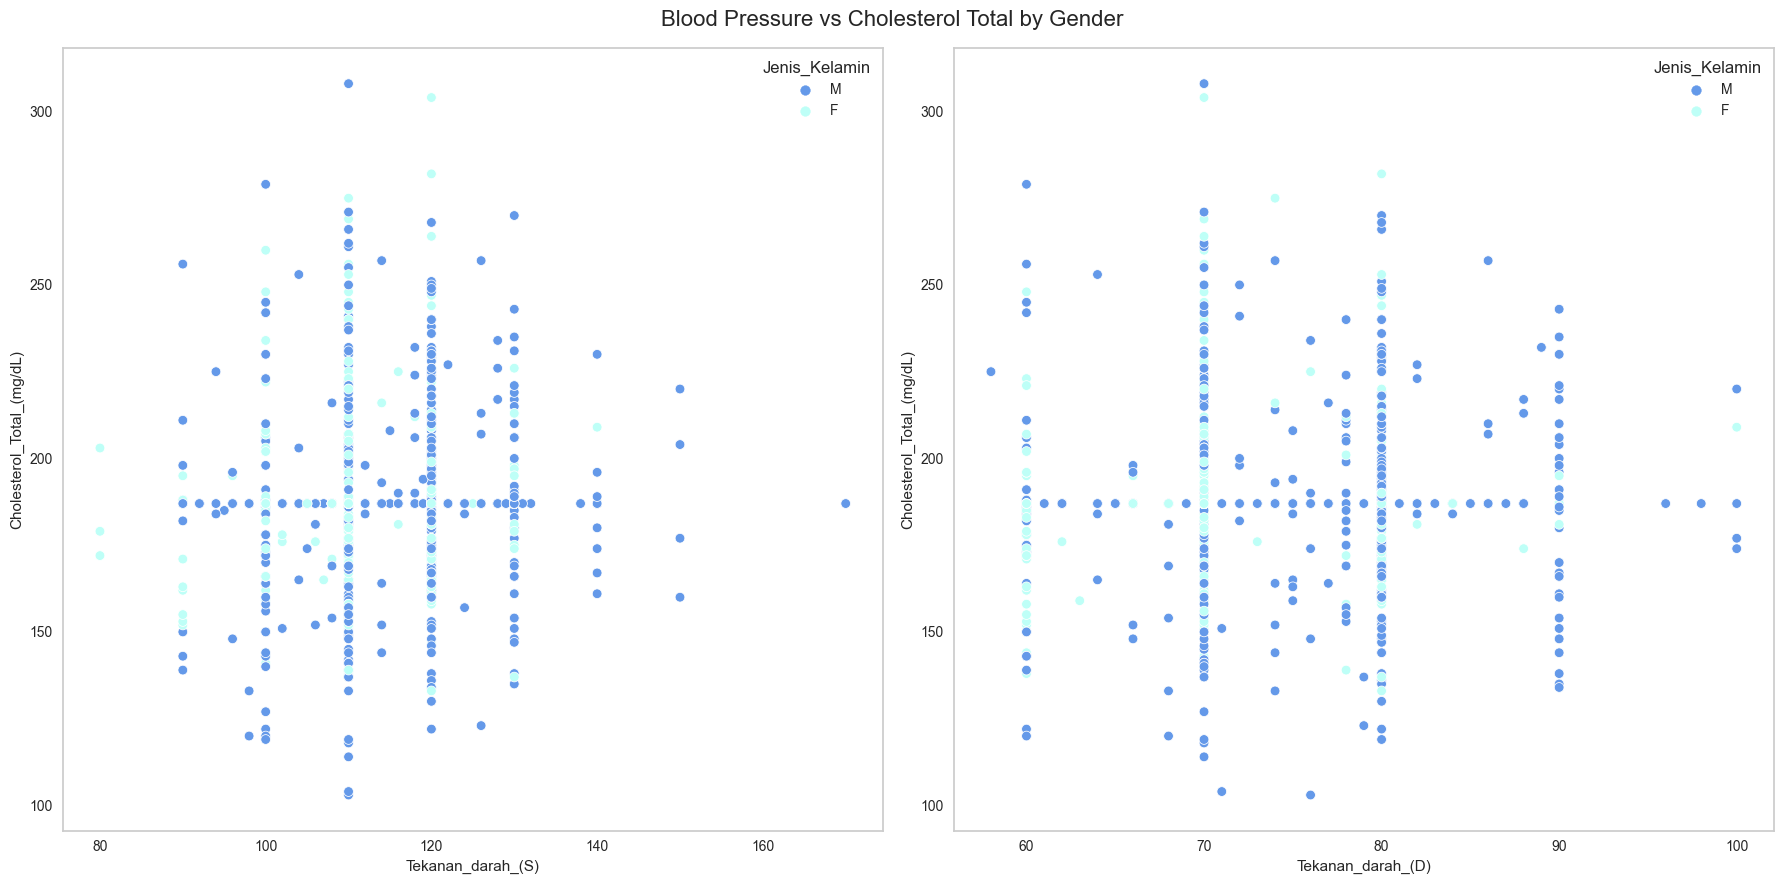

In [52]:
palette = ['#6499E9',  '#BEFFF7']
f,ax = plt.subplots(1,2,figsize=(18,9))

sns.scatterplot(x=df['Tekanan_darah_(S)'], y=df['Cholesterol_Total_(mg/dL)'],hue=df['Jenis_Kelamin'], palette=palette, ax=ax[0])
sns.scatterplot(x=df['Tekanan_darah_(D)'], y=df['Cholesterol_Total_(mg/dL)'],hue=df['Jenis_Kelamin'], palette=palette, ax=ax[1])
ax[0].grid(False)
ax[1].grid(False)

f.suptitle('Blood Pressure vs Cholesterol Total by Gender', fontsize=16,)

plt.tight_layout()
plt.show()

Plotnya menunjukkan bahwa pria cenderung memiliki tekanan darah lebih tinggi dibandingkan wanita. Namun, belum ada pola jelas yang menunjukkan bahwa tekanan darah mempengaruhi kadar kolesterol. Hal ini menunjukkan bahwa tekanan darah mungkin tidak berdampak langsung pada kadar kolesterol.

#### 1.3.2 Body Composition Analysis

Komposisi tubuh, aspek fundamental fisiologi manusia, mencakup pengukuran seperti tinggi badan, berat badan, indeks massa tubuh (BMI), dan lingkar pinggang. Metrik ini mencerminkan atribut fisik dan berfungsi sebagai indikator potensi risiko kesehatan.

Penggunaan metode ilmu data telah memungkinkan para peneliti dan petugas layanan kesehatan untuk mengeksplorasi hubungan antara berbagai faktor secara lebih mendalam. Hal ini memberikan wawasan yang dapat membantu mengembangkan perawatan kesehatan dan strategi pencegahan yang dipersonalisasi.
Salah satu teknik ilmu data ini adalah analisis pengelompokan, yang dapat mengidentifikasi kelompok-kelompok berbeda dalam suatu populasi yang memiliki karakteristik yang sama.

<Figure size 800x550 with 0 Axes>

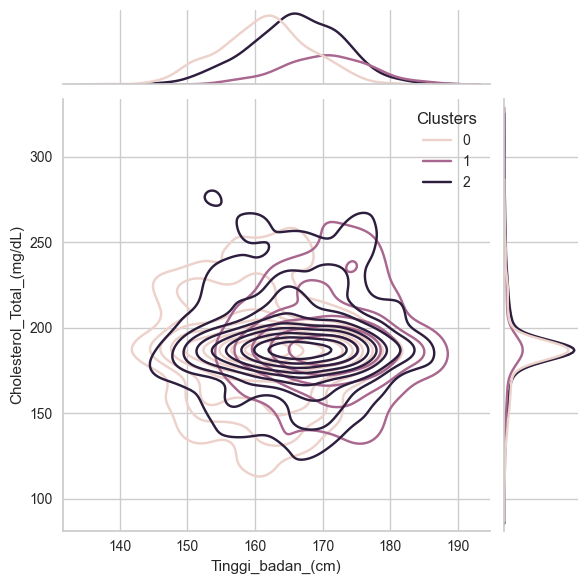

<Figure size 800x550 with 0 Axes>

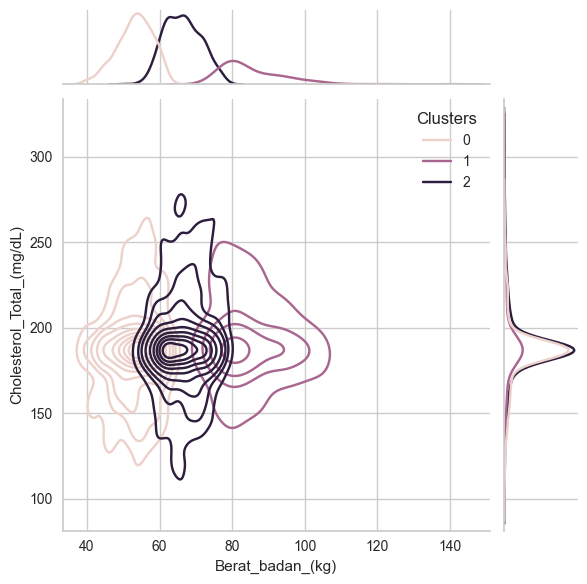

<Figure size 800x550 with 0 Axes>

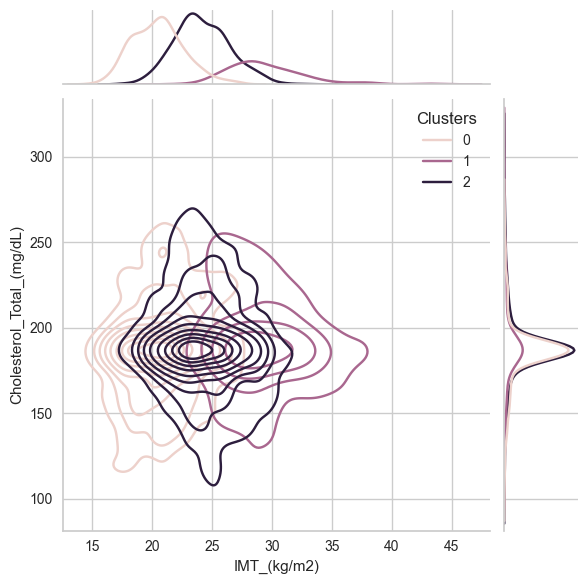

<Figure size 800x550 with 0 Axes>

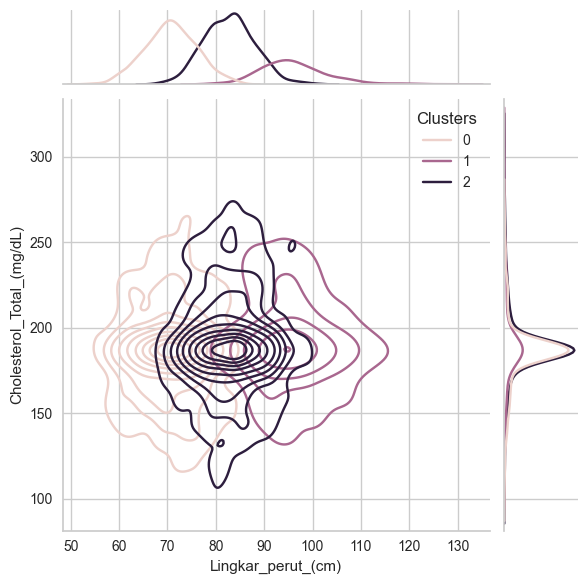

In [53]:
# For the sake of easy analysis, we will just set the num cluster to 3 
np.random.seed(42)

x = df.copy()
x = x[['Tinggi_badan_(cm)','Berat_badan_(kg)','IMT_(kg/m2)','Lingkar_perut_(cm)']]

kmeans = KMeans(n_clusters=3)
yhat_AC = kmeans.fit_predict(x)
x['clusters'] = yhat_AC
df['Clusters'] = yhat_AC

sub = ['Tinggi_badan_(cm)','Berat_badan_(kg)','IMT_(kg/m2)','Lingkar_perut_(cm)']

for i in sub:
    plt.figure()
    sns.jointplot(x=df[i], y=df["Cholesterol_Total_(mg/dL)"], hue =df["Clusters"], kind="kde")
    plt.show()

In [54]:
i = df[df['Cholesterol_Total_(mg/dL)'] >= 200].reset_index(drop=True)

i.groupby('Clusters')['Cholesterol_Total_(mg/dL)'].describe()

,count,mean,std,min,25%,50%,75%,max
Clusters,,,,,,,,
0,58.0,222.482759,17.240549,200.0,209.0,220.5,229.5,270.0
1,49.0,226.775510,20.996295,201.0,211.0,223.0,235.0,304.0
2,91.0,224.043956,22.205561,200.0,206.0,218.0,235.0,308.0


- Cluster 0: Kelompok ini mencakup individu dengan kisaran tinggi badan yang khas (146 - 187 cm) dan berat badan sedang (50 - 78 kg). Namun indeks massa tubuh (BMI) mereka sangat bervariasi (17 - 36), yang menunjukkan komposisi tubuh yang beragam. Meskipun demikian, lingkar pinggang mereka cenderung sedang (68 - 101 cm), menunjukkan distribusi lemak perut yang seimbang.

- Cluster 1: Individu dalam cluster ini memiliki kisaran tinggi badan yang beragam (138 - 180 cm) dan tubuh lebih ramping, dengan berat badan biasanya termasuk dalam kategori kurus (38 - 64 kg). Sebagian besar memiliki nilai BMI lebih rendah (14 - 27) dan lingkar pinggang lebih sempit (54 - 85 cm), yang menunjukkan lebih sedikit lemak perut dibandingkan kelompok lain.

- Cluster 2: Kelompok ini terdiri dari individu dengan tinggi badan normal hingga lebih tinggi (154 - 187 cm) dan profil tubuh lebih berat (71 - 139 kg). Mereka umumnya memiliki nilai BMI yang lebih tinggi (24 - 44) dan lingkar pinggang yang lebih lebar (80 - 128 cm), yang menunjukkan akumulasi lemak perut yang lebih tinggi.

Selain itu, penting untuk dicatat bahwa Cluster 2, dimana orang-orang memiliki akumulasi lemak perut yang lebih tinggi, memiliki sebagian besar individu dengan kadar kolesterol total tinggi melebihi 200. Namun, tidak jelas apakah tipe tubuh ini secara langsung menyebabkan kadar kolesterol lebih tinggi. Meskipun Cluster 2 memiliki lebih banyak orang dengan kolesterol tinggi, hal ini mungkin disebabkan oleh data yang tidak memadai atau bias. Jadi, sulit untuk mengatakan bahwa orang dengan akumulasi distribusi lemak perut yang lebih tinggi cenderung memiliki kadar kolesterol yang tinggi, namun secara umum hal tersebut mungkin benar.


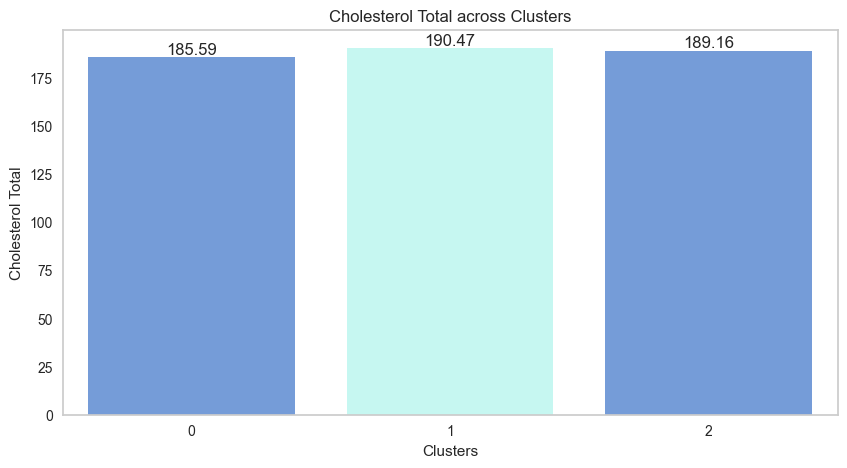

In [55]:
clus_0 = df[df['Clusters'] == 0]
clus_1 = df[df['Clusters'] == 1]
clus_2 = df[df['Clusters'] == 2]

grouped_clus_0 = clus_0.groupby('Clusters')['Cholesterol_Total_(mg/dL)'].mean()
grouped_clus_1 = clus_1.groupby('Clusters')['Cholesterol_Total_(mg/dL)'].mean()
grouped_clus_2 = clus_2.groupby('Clusters')['Cholesterol_Total_(mg/dL)'].mean()

grouped_all = pd.concat([clus_0, clus_1, clus_2], axis=0)

plt.figure(figsize=(10, 5))
ax = sns.barplot(x='Clusters', y='Cholesterol_Total_(mg/dL)', data=grouped_all, ci=None,palette=palette)
plt.title('Cholesterol Total across Clusters')
plt.xlabel('Clusters')
plt.ylabel('Cholesterol Total')
ax.grid(False)

for bar in ax.patches:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.05, f'{height:.2f}', ha='center', va='bottom')

plt.show()

df.drop(['Clusters'],axis=1,inplace=True)

Menarik untuk dicatat bagaimana rata-rata total kolesterol bervariasi antar kelompok. Yang mengejutkan, kelompok 1 memiliki rata-rata total kolesterol tertinggi, meskipun kelompok tersebut memiliki jumlah individu dengan kadar kolesterol tinggi yang paling sedikit (200 mg/dL). Hal ini mungkin terjadi karena cluster 1 memiliki populasi yang lebih kecil secara keseluruhan, namun proporsi individu yang memiliki kadar kolesterol tinggi lebih tinggi dibandingkan cluster lainnya.

#### 1.3.3 Grouping Health Indicators Analysis


<Figure size 800x550 with 0 Axes>

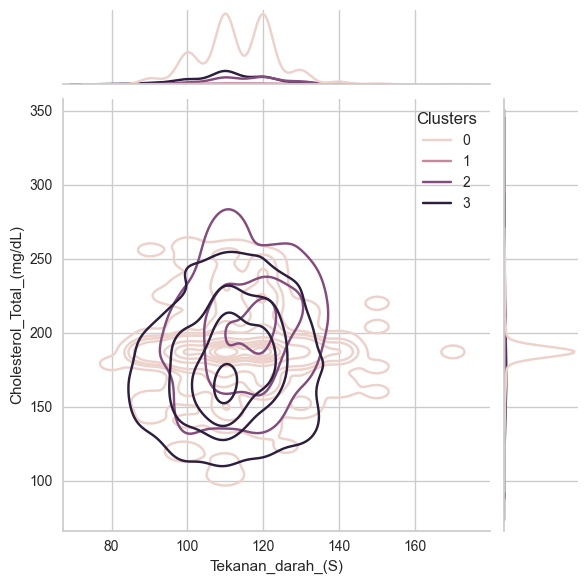

<Figure size 800x550 with 0 Axes>

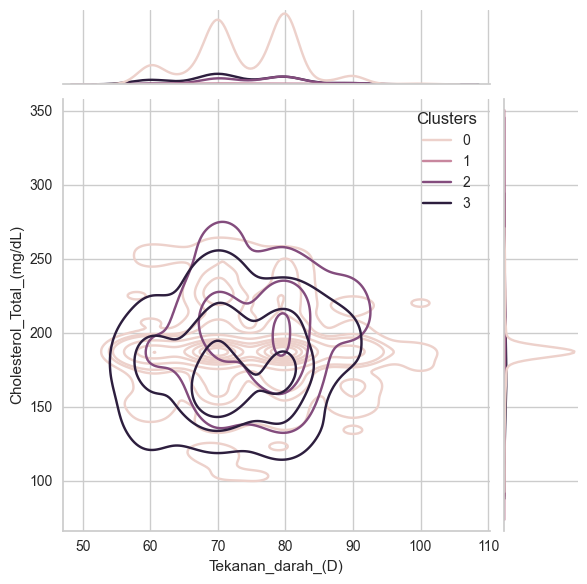

<Figure size 800x550 with 0 Axes>

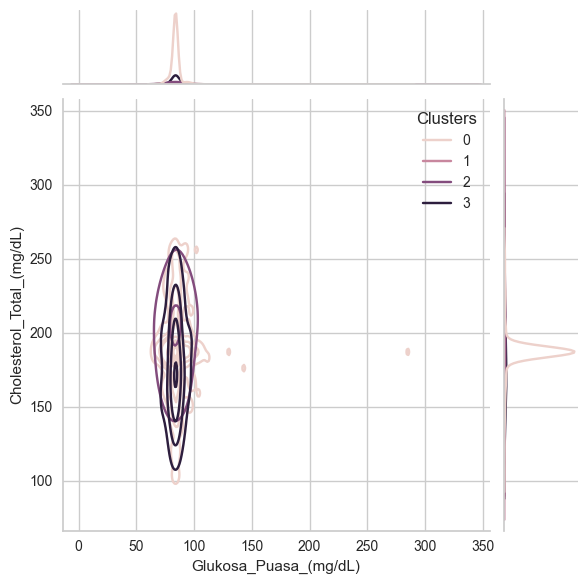

<Figure size 800x550 with 0 Axes>

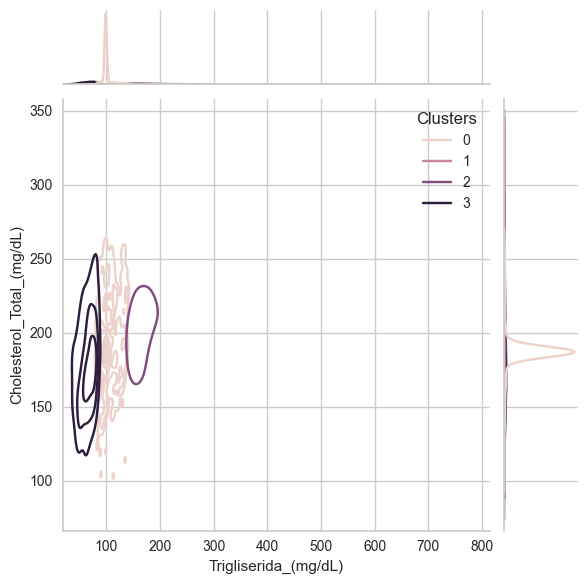

<Figure size 800x550 with 0 Axes>

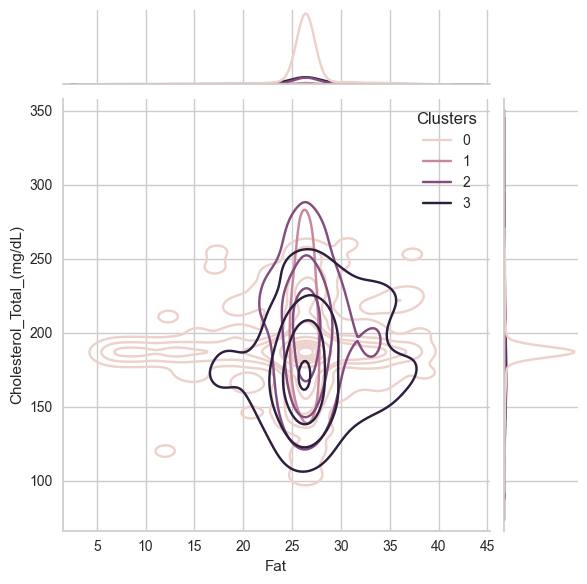

<Figure size 800x550 with 0 Axes>

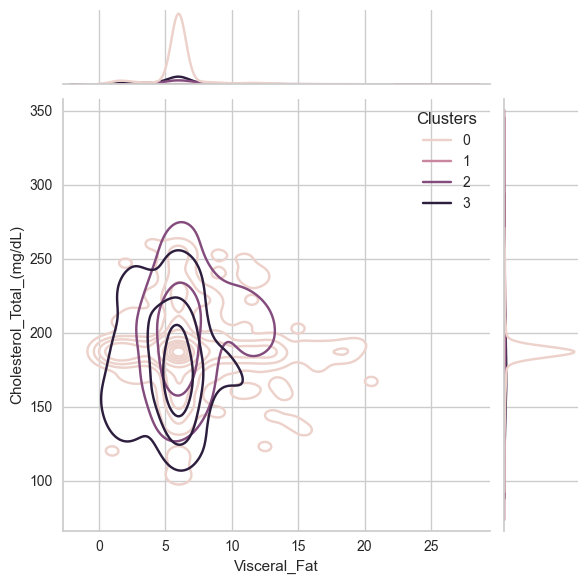

In [56]:
# For the sake of easy analysis, we will just set the num cluster to 4 
np.random.seed(42)

x = df.copy()
x = x[['Tekanan_darah_(S)', 'Tekanan_darah_(D)', 'Glukosa_Puasa_(mg/dL)', 'Trigliserida_(mg/dL)', 'Fat', 'Visceral_Fat']]

kmeans = KMeans(n_clusters=4, init='k-means++')
yhat_AC = kmeans.fit_predict(x)
x['clusters'] = yhat_AC
df['Clusters'] = yhat_AC

sub = ['Tekanan_darah_(S)', 'Tekanan_darah_(D)', 'Glukosa_Puasa_(mg/dL)', 'Trigliserida_(mg/dL)', 'Fat', 'Visceral_Fat']

for i in sub:
    plt.figure()
    sns.jointplot(x=df[i], y=df["Cholesterol_Total_(mg/dL)"], hue =df["Clusters"], kind="kde")
    plt.show()
    

In [57]:
i = df.copy()
analysis = i.groupby('Clusters')[['Cholesterol_Total_(mg/dL)', 'Tekanan_darah_(S)', 'Tekanan_darah_(D)', 'Glukosa_Puasa_(mg/dL)', 'Trigliserida_(mg/dL)', 'Fat', 'Visceral_Fat']].describe()

analysis = analysis[[('Cholesterol_Total_(mg/dL)', 'min'), ('Cholesterol_Total_(mg/dL)', 'count'), ('Cholesterol_Total_(mg/dL)', 'mean'), ('Cholesterol_Total_(mg/dL)', 'max'),
                     ('Tekanan_darah_(S)', 'min'), ('Tekanan_darah_(S)', 'count'), ('Tekanan_darah_(S)', 'mean'), ('Tekanan_darah_(S)', 'max'),
                     ('Tekanan_darah_(D)', 'min'), ('Tekanan_darah_(D)', 'count'), ('Tekanan_darah_(D)', 'mean'), ('Tekanan_darah_(D)', 'max'),
                     ('Glukosa_Puasa_(mg/dL)', 'min'), ('Glukosa_Puasa_(mg/dL)', 'count'), ('Glukosa_Puasa_(mg/dL)', 'mean'), ('Glukosa_Puasa_(mg/dL)', 'max'),
                     ('Trigliserida_(mg/dL)', 'min'), ('Trigliserida_(mg/dL)', 'count'), ('Trigliserida_(mg/dL)', 'mean'), ('Trigliserida_(mg/dL)', 'max'),
                     ('Fat', 'min'), ('Fat', 'count'), ('Fat', 'mean'), ('Fat', 'max'),
                     ('Visceral_Fat', 'min'), ('Visceral_Fat', 'count'), ('Visceral_Fat', 'mean'), ('Visceral_Fat', 'max')]]
analysis.T


Clusters                                  0           1           2  \
Cholesterol_Total_(mg/dL) min    103.000000  142.000000  127.000000   
                          count  994.000000   21.000000  129.000000   
                          mean   187.691147  209.047619  201.968992   
                          max    260.000000  282.000000  308.000000   
Tekanan_darah_(S)         min     80.000000  100.000000   90.000000   
                          count  994.000000   21.000000  129.000000   
                          mean   113.238431  113.333333  115.410853   
                          max    170.000000  130.000000  140.000000   
Tekanan_darah_(D)         min     58.000000   60.000000   60.000000   
                          count  994.000000   21.000000  129.000000   
                          mean    74.068410   72.857143   76.054264   
                          max    100.000000   80.000000  100.000000   
Glukosa_Puasa_(mg/dL)     min     66.000000   65.000000   69.000000   
                          count  994.000000   21.000000  129.000000   
                          mean    84.161972   95.761905   86.069767   
                          max    285.000000  277.000000  321.000000   
Trigliserida_(mg/dL)      min     82.000000  263.000000  141.000000   
                          count  994.000000   21.000000  129.000000   
                          mean   100.933602  341.047619  178.573643   
                          max    139.000000  634.000000  254.000000   
Fat                       min      5.800000   23.000000   10.500000   
                          count  994.000000   21.000000  129.000000   
                          mean    26.097485   26.490476   26.589147   
                          max     38.600000   32.100000   40.900000   
Visceral_Fat              min      0.500000    6.000000    1.500000   
                          count  994.000000   21.000000  129.000000   
                          mean     6.172535    8.309524    7.312403   
                          max     20.500000   21.000000   22.000000   

Clusters                                  3  
Cholesterol_Total_(mg/dL) min    118.000000  
                          count  195.000000  
                          mean   178.035897  
                          max    264.000000  
Tekanan_darah_(S)         min     80.000000  
                          count  195.000000  
                          mean   111.169231  
                          max    140.000000  
Tekanan_darah_(D)         min     60.000000  
                          count  195.000000  
                          mean    72.482051  
                          max    100.000000  
Glukosa_Puasa_(mg/dL)     min     67.000000  
                          count  195.000000  
                          mean    84.461538  
                          max    194.000000  
Trigliserida_(mg/dL)      min     34.000000  
                          count  195.000000  
                          mean    65.251282  
                          max     83.000000  
Fat                       min      6.800000  
                          count  195.000000  
                          mean    26.457949  
                          max     39.300000  
Visceral_Fat              min      1.000000  
                          count  195.000000  
                          mean     5.592308  
                          max     23.000000

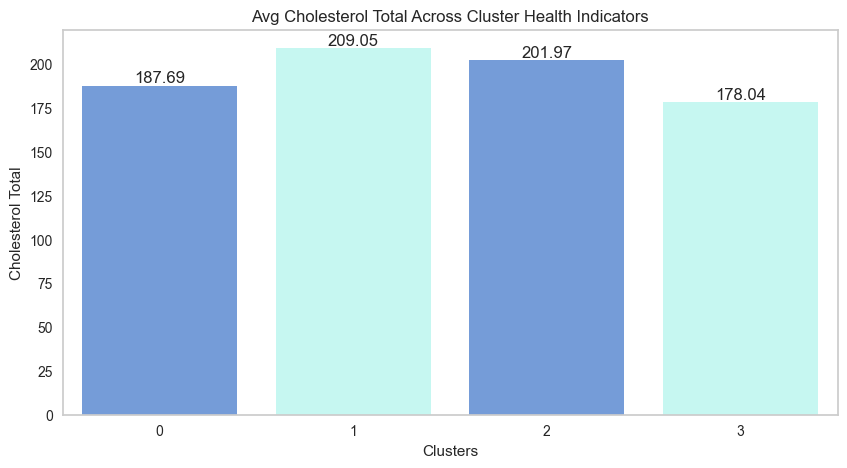

In [58]:
i = df.groupby('Clusters')[['Cholesterol_Total_(mg/dL)']].mean().reset_index()
plt.figure(figsize=(10, 5))
ax = sns.barplot(x='Clusters', y='Cholesterol_Total_(mg/dL)', data=i, ci=None,palette=palette)
plt.title('Avg Cholesterol Total Across Cluster Health Indicators')
plt.xlabel('Clusters')
plt.ylabel('Cholesterol Total')
ax.grid(False)

for bar in ax.patches:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.05, f'{height:.2f}', ha='center', va='bottom')

plt.show()

df.drop(['Clusters'],axis=1,inplace=True)

- Cluster 0: Kelompok Moderat Cluster ini dicirikan oleh individu dengan tekanan darah dalam kisaran yang relatif normal, dengan rata-rata sistolik sekitar 113 dan diastolik sekitar 74. Kadar glukosa puasa mereka juga berada dalam kisaran standar, rata-rata 84. Khususnya, trigliserida mereka levelnya berada di batas bawah, rata-rata sedikit di atas 100, yang dianggap diinginkan. Persentase lemak rata-rata adalah sedang, dan kadar lemak visceral rendah, menunjukkan profil metabolisme yang lebih sehat secara keseluruhan.

- Kelompok 1: Kelompok Berisiko Tinggi Di sini, kami menemukan individu dengan tingkat tekanan darah yang sedikit lebih tinggi, namun tingkat trigliserida merekalah yang menonjol, melonjak hingga rata-rata 341, yang jauh di atas kisaran normal dan menunjukkan faktor risiko yang signifikan untuk masalah kolesterol. Kadar glukosa puasa mereka juga meningkat, rata-rata sekitar 95, yang bisa menandakan pradiabetes atau sindrom metabolik. Kelompok ini memiliki rata-rata lemak visceral tertinggi, yang dikaitkan dengan peningkatan risiko kardiovaskular.

- Cluster 2: Kelompok Tinggi Individu dalam cluster ini memiliki rata-rata tekanan darah sistolik tertinggi yaitu 115 dan tekanan diastolik lebih tinggi. Kadar glukosa puasa mereka sedikit meningkat, dengan rata-rata 86, dan kadar trigliserida mereka jauh lebih tinggi dibandingkan Cluster 0, dengan rata-rata 178. Hal ini menunjukkan profil metabolisme yang mengarah pada potensi masalah kesehatan. Rata-rata lemak visceral lebih tinggi dibandingkan Cluster 0 namun lebih rendah dibandingkan Cluster 1, sehingga menempatkan mereka pada risiko menengah.

- Cluster 3: Kelompok Trigliserida Rendah Kelompok ini menyajikan profil yang menarik dengan rata-rata tekanan darah yang mirip dengan Cluster 0, namun kadar trigliseridanya jauh lebih rendah, rata-rata 65, yang cukup bermanfaat bagi kesehatan jantung. Kadar glukosa puasa mereka sebanding dengan Cluster 0, dan rata-rata lemak visceral mereka adalah yang terendah di antara semua cluster, sebuah tanda positif mengenai kesehatan metabolisme.

Cluster 1 tampaknya memiliki profil risiko tertinggi berdasarkan nilai rata-rata yang lebih tinggi untuk tekanan darah sistolik, glukosa puasa, trigliserida, dan lemak visceral. Cluster 0, 2, dan 3 memiliki nilai rata-rata yang relatif lebih rendah untuk parameter-parameter ini, yang mengindikasikan potensi profil risiko kardiovaskular yang lebih rendah.

#### 1.3.4 How do triglyceride levels correlate with total cholesterol levels

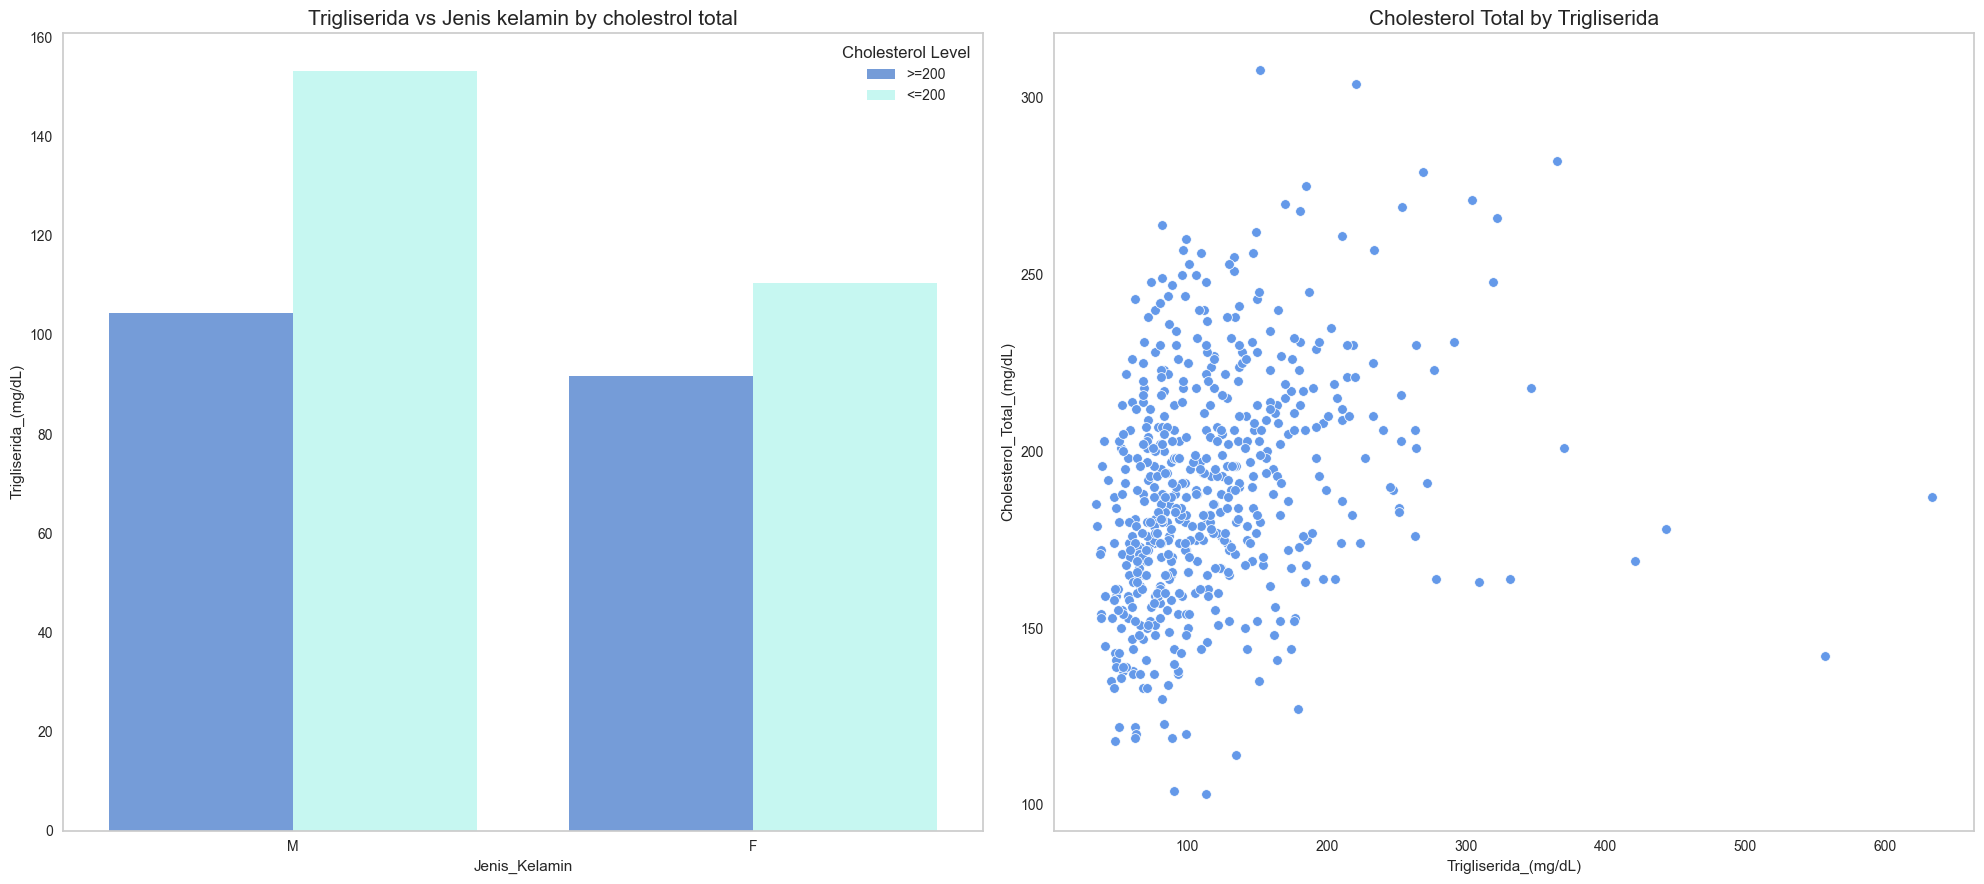

In [59]:
x = df.copy()

f, ax = plt.subplots(1,2,figsize=(20,9))
sns.barplot(x=x['Jenis_Kelamin'], y=x['Trigliserida_(mg/dL)'], hue=x['Cholesterol_Total_Map'], ax=ax[0], palette=palette, ci=None)
sns.scatterplot(x=x['Trigliserida_(mg/dL)'], y=df['Cholesterol_Total_(mg/dL)'],ax=ax[1], color='#6499E9')

ax[0].set_title('Trigliserida vs Jenis kelamin by cholestrol total', size=15)
ax[1].set_title('Cholesterol Total by Trigliserida', size=15)
ax[0].grid(False)
ax[1].grid(False)

# Customize legend labels
legend_labels = {'>=200': '>=200', '<=200': '<=200'}
handles, _ = ax[0].get_legend_handles_labels()
ax[0].legend(handles, legend_labels.values(),  title='Cholesterol Level')

plt.tight_layout()
plt.show()

Trigliserida dan kolesterol keduanya merupakan jenis lemak dalam darah Anda, namun keduanya bukanlah hal yang sama. Trigliserida adalah bagian dari apa yang diukur saat memeriksa kolesterol total. Meskipun mereka terhubung, namun tidak selalu jelas. Kita tidak selalu bisa mengatakan bahwa jika trigliserida tinggi, maka kolesterol total juga akan tinggi.

Kadar trigliserida yang tinggi bisa menimbulkan risiko tersendiri. Bahan-bahan tersebut dapat menyebabkan arteriosklerosis, yang mengeraskan arteri, meningkatkan kemungkinan masalah jantung seperti gagal jantung, stroke, dan serangan jantung.

Dari plot tersebut, terlihat bahwa laki-laki lebih cenderung memiliki kadar trigliserida dan kolesterol total yang lebih tinggi dibandingkan perempuan.

#### 1.3.5 Relationship of High Visceral Fat and Cardiovascular Risk Factors on Cholesterol Total

Faktor Risiko Kardiovaskular mengacu pada variabel yang berhubungan dengan peningkatan kemungkinan terkena penyakit atau kondisi kardiovaskular. Faktor-faktor ini termasuk tekanan darah, glukosa puasa, kolesterol total, IMT, dan kadar trigliserida, yang masing-masing memainkan peran penting dalam menilai kesehatan jantung seseorang.

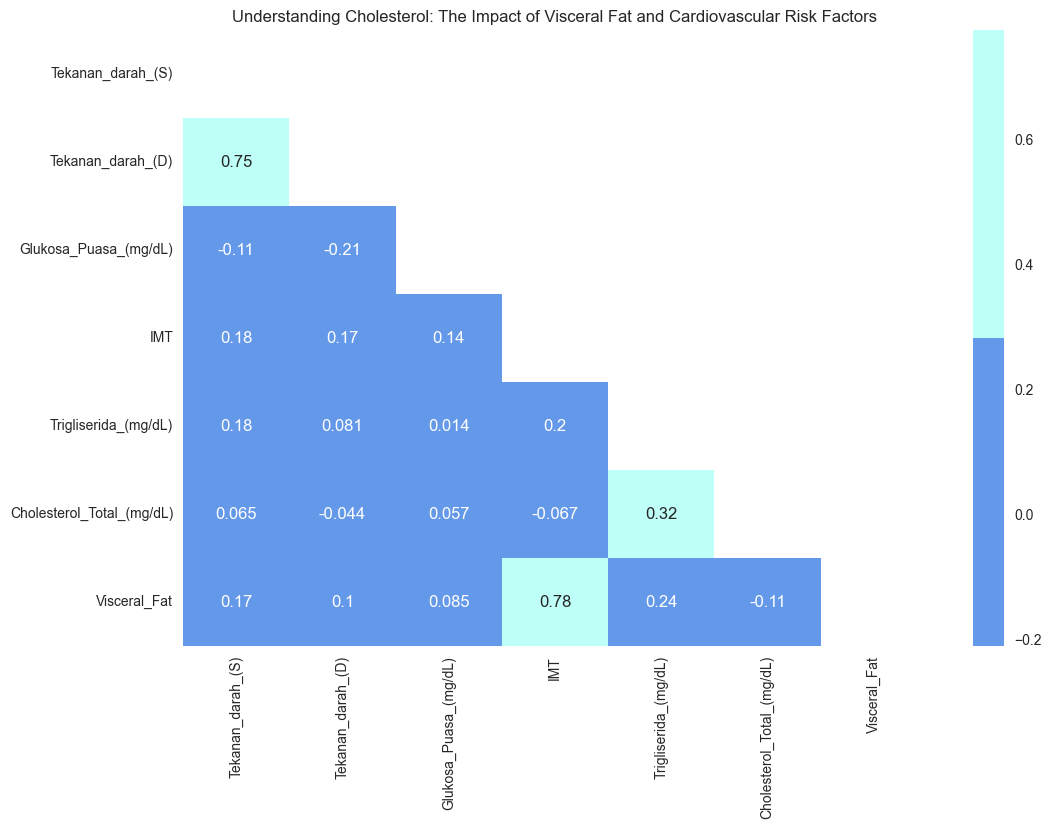

Summary Statistics for Cardiovascular Risk Factors in High-Risk Individuals:
       Tekanan_darah_(S)  Tekanan_darah_(D)  Glukosa_Puasa_(mg/dL)        IMT  \
count          89.000000          89.000000              89.000000  89.000000   
mean          119.438202          78.101124              84.550562  28.175594   
std            10.565763           6.982193               7.311279   2.823367   
min            90.000000          60.000000              68.000000  21.672911   
25%           110.000000          70.000000              84.000000  26.297824   
50%           120.000000          80.000000              84.000000  27.716263   
75%           126.000000          80.000000              84.000000  29.410759   
max           150.000000         100.000000             119.000000  38.399124   

       Trigliserida_(mg/dL)  Cholesterol_Total_(mg/dL)  
count             89.000000                  89.000000  
mean             130.775281                 190.415730  
std               62.6

In [60]:
threshold_visceral_fat = 10  # Considered as high visceral fat

high_risk_individuals = df[df['Visceral_Fat'] >= threshold_visceral_fat]
risk_factors = ['Tekanan_darah_(S)', 'Tekanan_darah_(D)', 'Glukosa_Puasa_(mg/dL)', 'IMT', 'Trigliserida_(mg/dL)', 'Cholesterol_Total_(mg/dL)']

summary_statistics = high_risk_individuals[risk_factors].describe()
correlation_matrix = high_risk_individuals[risk_factors + ['Visceral_Fat']].corr()


f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, mask=np.triu(correlation_matrix), cmap=palette)
ax.grid(False)

ax.set_title('Understanding Cholesterol: The Impact of Visceral Fat and Cardiovascular Risk Factors')

plt.show()

print("Summary Statistics for Cardiovascular Risk Factors in High-Risk Individuals:")
print(summary_statistics)

Saat kami melihat ciri-ciri yang terkait dengan kadar lemak visceral yang tinggi (di atas 10), kami menemukan beberapa hubungan menarik. Pertama, seiring dengan peningkatan IMT, lemak visceral juga meningkat. Hal ini masuk akal karena IMT adalah ukuran lemak tubuh.
Kedua, kami melihat hubungan antara kadar trigliserida dan lemak visceral, meskipun tidak sekuat hubungan antara IMT dan Lemak. Yang mengejutkan, kadar trigliserida juga dikaitkan dengan kolesterol total.

Meskipun hubungan antara lemak visceral dan kolesterol total tidak terlalu kuat, namun hubungan ini tetap signifikan. Ini menempati urutan kedua di antara semua fitur yang kami lihat setelah kadar trigliserida. Ini berarti lemak visceral yang tinggi mungkin berperan dalam kadar kolesterol dan pemahaman kita tentang kesehatan jantung, meskipun itu bukan faktor utamanya.

#### 1.3.6 Outliers Detection with IsolationForest

Metode pendeteksian outlier yang dipilih adalah IsolationForest. Metode ansambel ini mengisolasi outlier dengan cara memilih suatu fitur secara acak kemudian secara acak memilih nilai pemisahan antara nilai maksimum dan minimum dari fitur yang dipilih.

Metode ini dipilih karena hanya beberapa fitur yang mengikuti distribusi normal, sehingga membuat metode tradisional seperti IQR lebih buruk pada beberapa fitur, seperti Trigliserida. Jadi, hutan isolasi dipilih karena merupakan algoritma deteksi anomali berbasis pohon yang bekerja dengan baik untuk mendeteksi outlier pada kumpulan data dengan distribusi normal dan non-normal. Ini juga efisien untuk kumpulan data kecil.

In [61]:
Tune = False

c = df.copy()
num_cols = [col for col in c.columns if c[col].dtype != 'object'][1:-4]
num_cols

['Usia',
 'Tekanan_darah_(S)',
 'Tekanan_darah_(D)',
 'Tinggi_badan_(cm)',
 'Berat_badan_(kg)',
 'IMT_(kg/m2)',
 'Lingkar_perut_(cm)',
 'Glukosa_Puasa_(mg/dL)',
 'Cholesterol_Total_(mg/dL)',
 'Trigliserida_(mg/dL)',
 'Fat',
 'Visceral_Fat']

In [62]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_samples = trial.suggest_uniform('max_samples', 0.1, 0.9)
    contamination = trial.suggest_uniform('contamination', 0.01, 0.1)
    
    model = IsolationForest(n_estimators=n_estimators,
                            max_samples=max_samples,
                            contamination=contamination,
                            random_state=42)
    
    X_train, X_val = train_test_split(c[num_cols], test_size=0.2, random_state=42)
    model.fit(X_train)
    
    outlier_scores = model.decision_function(X_val)
    
    score = -mean_squared_error(outlier_scores, [0]*len(X_val))  # Assuming all samples are inliers
    
    return score

if Tune:
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)

    best_params = study.best_params
    print("Best Hyperparameters:", best_params)

In [63]:
params = {'n_estimators': 142,
 'max_samples': 0.865283998525136,
 'contamination': 0.09954498297322326}

best_isolation_forest = IsolationForest(**params, random_state=42)
best_isolation_forest.fit(c[num_cols])
outliers = best_isolation_forest.predict(c[num_cols])
c['IsOutlier'] = outliers

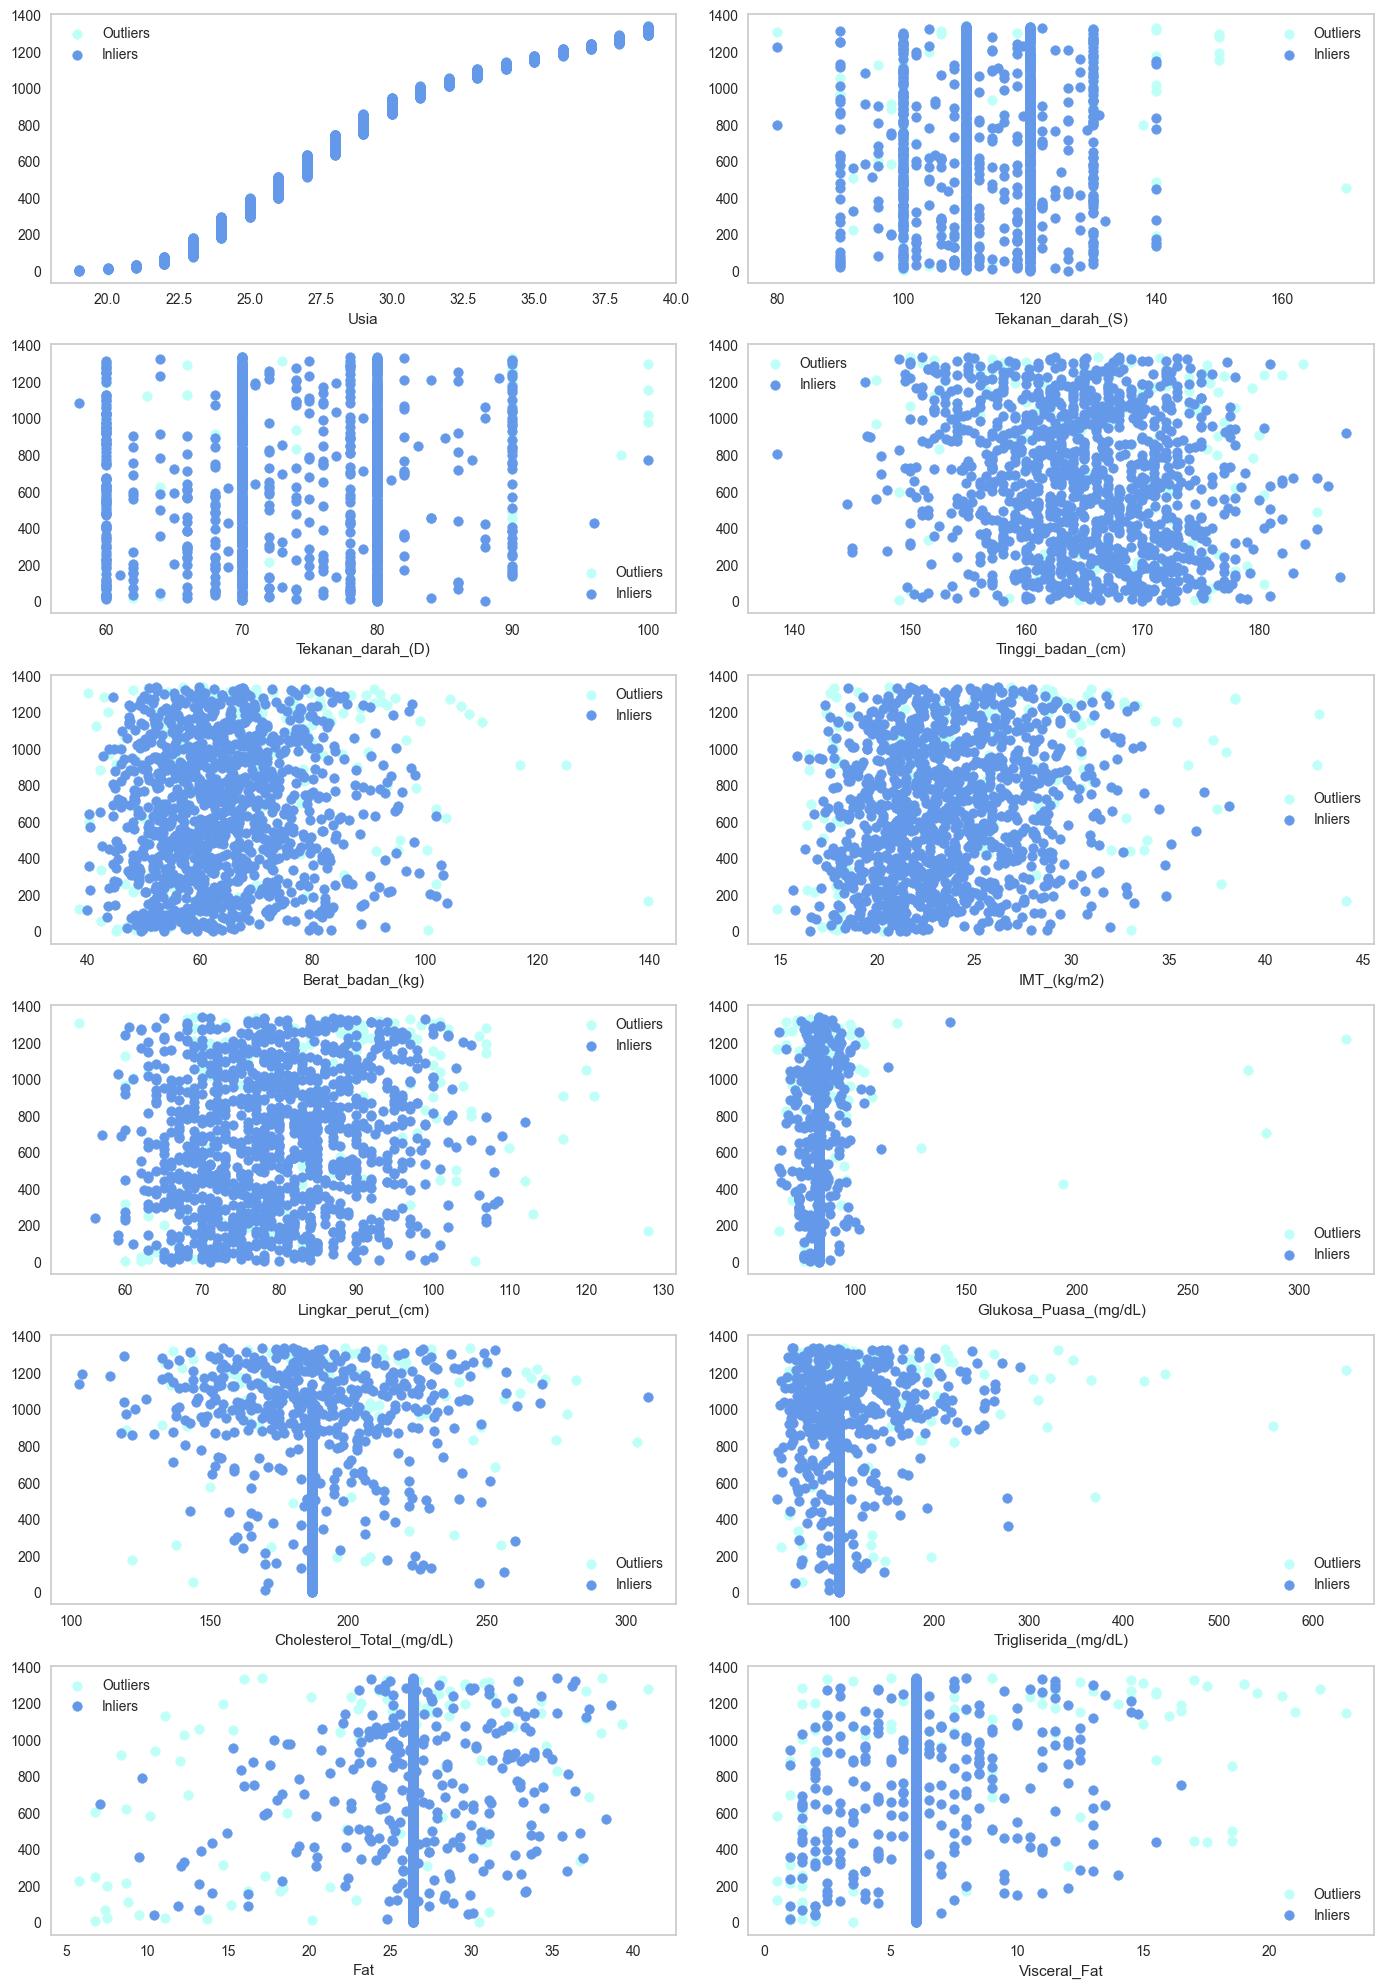

In [64]:
outliers = c[c['IsOutlier'] == -1]
inliers = c[c['IsOutlier'] == 1]

num_features = len(num_cols)
num_rows = (num_features + 1) // 2  # Calculate the number of rows needed

f, ax = plt.subplots(num_rows, 2, figsize=(14, 20))

for i, col in enumerate(num_cols):
    ax[i//2, i%2].scatter(outliers[col], outliers.index, color='#BEFFF7', label='Outliers')
    ax[i//2, i%2].scatter(inliers[col], inliers.index, color='#6499E9', label='Inliers')
    
    # Add x-label to each subplot
    ax[i//2, i%2].set_xlabel(col)
    ax[i//2, i%2].grid(False)

# Hide the unused subplot
if num_features % 2 != 0:
    f.delaxes(ax[num_rows - 1, 1])

for ax_row in ax:
    for axis in ax_row:
        axis.legend()

plt.tight_layout()
plt.show()

Hasilnya nampaknya menjanjikan; model ini memiliki kinerja yang cukup baik, bahkan dengan fitur yang sangat miring seperti "Glukosa Puasa" dan "Trigliserida". Namun, kami memutuskan untuk hanya mengatasi beberapa outlier selama fase pemodelan karena terbatasnya ukuran kumpulan data. Pendekatan ini membantu kami mempertahankan seluruh variasi fitur, menghindari potensi kehilangan informasi berharga.

## 1.3 **Multivariate Analysis** <a class="anchor" id="1.1"></a>
Analisis multivariat ini bertujuan untuk menjelajahi hubungan antara beberapa variabel secara bersama-sama. Dalam konteks ini, kita akan melihat korelasi antara variabel-variabel tersebut menggunakan tiga metode: korelasi Pearson, korelasi point biserial, dan koefisien korelasi Cramers.

Korelasi Pearson digunakan untuk mengukur hubungan linear antara dua variabel numerik. Korelasi point biserial digunakan untuk mengukur hubungan antara satu variabel numerik dan satu variabel kategorikal dengan dua level. Sedangkan, koefisien korelasi Cramers digunakan untuk mengukur hubungan antara dua variabel kategorikal dengan lebih dari dua level.

#### 1.3.1 Correlation Analysis with Pearson
Koefisien korelasi Pearson adalah statistik yang digunakan dalam mengukur relationship linearitas antara dua variabel continue. 

Nilai korelasi Pearson berkisar dari -1 hingga +1.
- Nilai positif (+1) menunjukkan hubungan positif (saat satu variabel naik, variabel lainnya cenderung naik juga). 
- Nilai negatif (-1) menunjukkan hubungan negatif (saat satu variabel naik, variabel lainnya cenderung turun).
- Nilai mendekati nol menunjukkan tidak adanya hubungan linier antara variabel tersebut. 

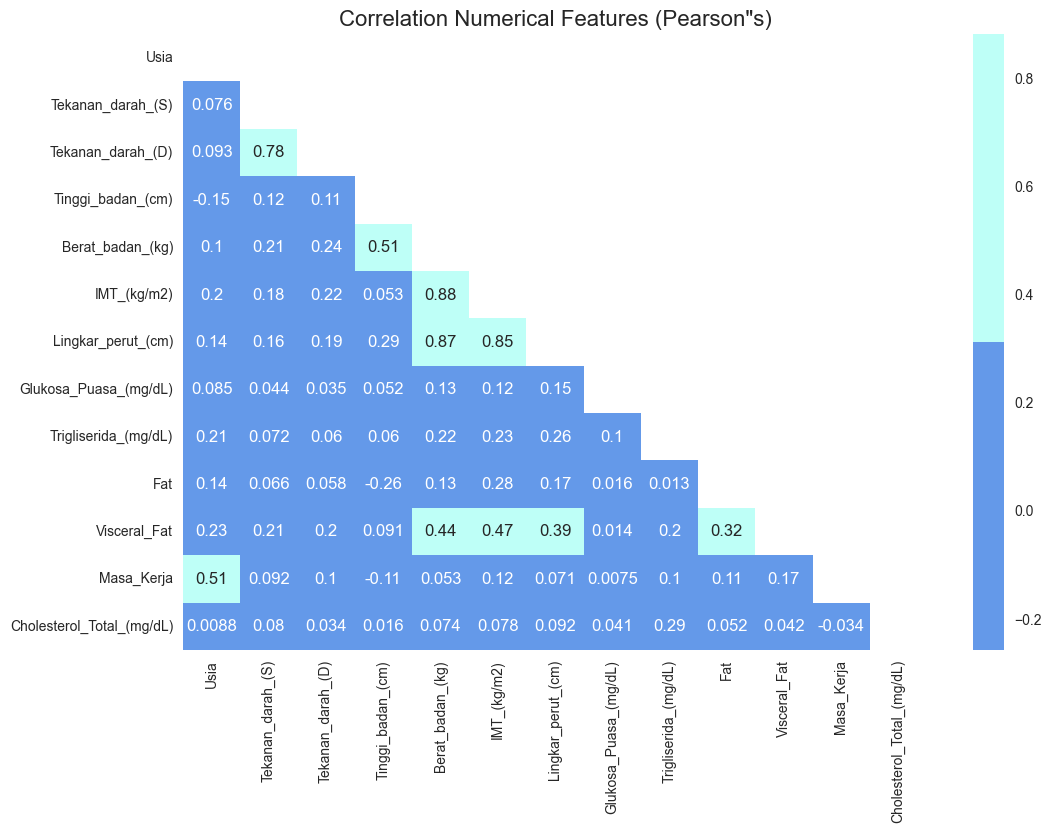

In [65]:
num_cols = [col for col in c.columns if c[col].dtype != 'object'][1:-4]
num_cols.remove('Cholesterol_Total_(mg/dL)')
num_cols.append('Cholesterol_Total_(mg/dL)')
corr = df[num_cols].corr(method='pearson')

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
sns.heatmap(corr, annot=True, mask=np.triu(corr), cmap=palette)
ax.grid(False)

ax.set_title('Correlation Numerical Features (Pearson"s)', fontsize=16)

plt.show()

In [66]:
for col in num_cols:
    correlation, p_value = pearsonr(df[col], df['Cholesterol_Total_(mg/dL)'])
    if p_value < 0.005:
        print(f"Feature '{col}' has a significant linear relationship with the label (Correlation: {correlation:.4f}, p-value: {p_value:.4f})")
    else:
        print(f"Feature '{col}' does not have a significant linear relationship with the label (Correlation: {correlation:.4f}, p-value: {p_value:.4f})")

Feature 'Usia' does not have a significant linear relationship with the label (Correlation: 0.0088, p-value: 0.7479)
Feature 'Tekanan_darah_(S)' has a significant linear relationship with the label (Correlation: 0.0800, p-value: 0.0034)
Feature 'Tekanan_darah_(D)' does not have a significant linear relationship with the label (Correlation: 0.0344, p-value: 0.2087)
Feature 'Tinggi_badan_(cm)' does not have a significant linear relationship with the label (Correlation: 0.0161, p-value: 0.5567)
Feature 'Berat_badan_(kg)' does not have a significant linear relationship with the label (Correlation: 0.0737, p-value: 0.0069)
Feature 'IMT_(kg/m2)' has a significant linear relationship with the label (Correlation: 0.0780, p-value: 0.0043)
Feature 'Lingkar_perut_(cm)' has a significant linear relationship with the label (Correlation: 0.0917, p-value: 0.0008)
Feature 'Glukosa_Puasa_(mg/dL)' does not have a significant linear relationship with the label (Correlation: 0.0413, p-value: 0.1308)
Featu

Dapat dilihat hasil dari plot, ada beberapa features yang dapat diperhatikan karena memiliki indikasi mempunyai hubungan korelasi yang kuat antar variabel lainnya (>0.5), ini dapat membantah asumsi dalam pemodelan independence.

Berikut beberapa featurs yang terindikasi tidak memnuhi assumption independence:
- Usia dan Masa Kerja (Korelasi 0,51)

Terdapat kecenderungan bahwa ketika usia seseorang meningkat, masa kerjanya juga cenderung meningkat, dan sebaliknya. Hal ini dapat dimengerti karena umumnya individu yang lebih tua telah memiliki pengalaman kerja yang lebih lama. Seiring bertambahnya usia, biasanya individu telah menyelesaikan pendidikan dan memasuki dunia kerja. Semakin lama mereka berada di dunia kerja, semakin tinggi masa kerja yang mereka miliki.
- Tekanan Darah (S) dan Tekanan Darah (D) (Korelasi 0,78)

Terdapat hubungan yang kuat antara tekanan darah sistolik (S) dan diastolik (D), dengan nilai korelasi sebesar 0,78. Hal ini menunjukkan bahwa ketika tekanan darah sistolik meningkat, kemungkinan besar tekanan darah diastolik juga akan meningkat, dan sebaliknya. Ini mencerminkan hubungan fisiologis di mana perubahan dalam tekanan darah satu jenis umumnya disertai dengan perubahan dalam tekanan darah jenis lainnya.
- Tinggi Badan dan Berat Badan (Korelasi 0,51)

Terdapat hubungan yang sedang antara tinggi badan dan berat badan, dengan korelasi sebesar 0,51. Ini mengindikasikan bahwa umumnya, individu dengan tinggi badan yang lebih tinggi cenderung memiliki berat badan yang lebih besar, dan sebaliknya. Namun, penting untuk diingat bahwa hubungan ini tidak selalu terjadi secara konsisten karena faktor-faktor lain seperti komposisi tubuh individu juga memainkan peran.
- Lingkar Perut dan Berat Badan (Korelasi 0,87)

Terdapat hubungan yang sangat kuat antara lingkar perut dan berat badan, dengan korelasi sebesar 0,87. Hal ini menunjukkan bahwa individu dengan lingkar perut yang lebih besar umumnya memiliki berat badan yang lebih besar, dan sebaliknya. Lingkar perut sering digunakan sebagai indikator akumulasi lemak di sekitar perut, dan karena itu, hubungan yang kuat ini tidak mengejutkan.
- Berat Badan dan IMT (kg_m2) (Korelasi 0,88)

Terdapat hubungan yang sangat kuat antara berat badan dan Indeks Massa Tubuh (IMT), dengan korelasi sebesar 0,88. Ini menunjukkan bahwa semakin tinggi berat badan seseorang, semakin tinggi pula nilai IMT mereka. IMT adalah pengukuran standar yang digunakan untuk menilai apakah seseorang memiliki berat badan yang sehat berdasarkan tinggi badan mereka. Oleh karena itu, hubungan yang kuat ini mencerminkan kaitan yang erat antara berat badan dan IMT.
- Lingkar Perut dan IMT (kg_m2) (Korelasi 0,85)

Terdapat hubungan yang kuat antara lingkar perut dan IMT, dengan korelasi sebesar 0,85. Ini menunjukkan bahwa individu dengan lingkar perut yang lebih besar cenderung memiliki nilai IMT yang lebih tinggi, dan sebaliknya. Lingkar perut sering digunakan sebagai indikator akumulasi lemak di sekitar perut, yang dapat berkontribusi pada peningkatan nilai IMT. Hubungan yang kuat ini menunjukkan pentingnya pengukuran lingkar perut dalam mengevaluasi risiko kesehatan terkait obesitas.





#### 1.3.2 Correlation Analysis with Point Biserial
Dalam konteks ini, kami menggunakan koefisien korelasi Point Biserial untuk mengukur kekuatan dan arah hubungan antara setiap variable continue dan variable categorical tersebut. Variable continue merujuk pada variabel numerik yang memiliki rentang nilai kontinu, seperti usia, tinggi badan, atau glukosa darah. Di sisi lain, Variable categorical mengacu pada variabel yang menggambarkan kategori atau kelompok, seperti jenis kelamin atau kategori IMT.

Korelasi point-biserial sesungguhnya sama dengan korelasi product moment Pearson, maka nilai koefisien ini berkisar antara -1,00 sampai dengan +1,00. Dalam seleksi item, hanya nilai positif saja yang dapat dianggap sebagai item yang baik, karena nilai negatif menunjukkan fungsi diskriminasi yang terbalik.

In [67]:
df['Cholesterol_Total_Map'] = df['Cholesterol_Total_Map'].replace({'Tinggi': 1, 'Rendah': 0})
num_cols = [col for col in c.columns if c[col].dtype != 'object'][1:-4]
num_cols.remove('Cholesterol_Total_(mg/dL)')
num_cols.append('Cholesterol_Total_Map')

In [68]:
def point_biserial(x, y):
    pb = stats.pointbiserialr(x, y)
    return pb[0]

rows= []
for x in num_cols:
    col = []
    for y in num_cols :
        pbs =point_biserial(df[x], df[y]) 
        col.append(round(pbs,2))  
    rows.append(col)  

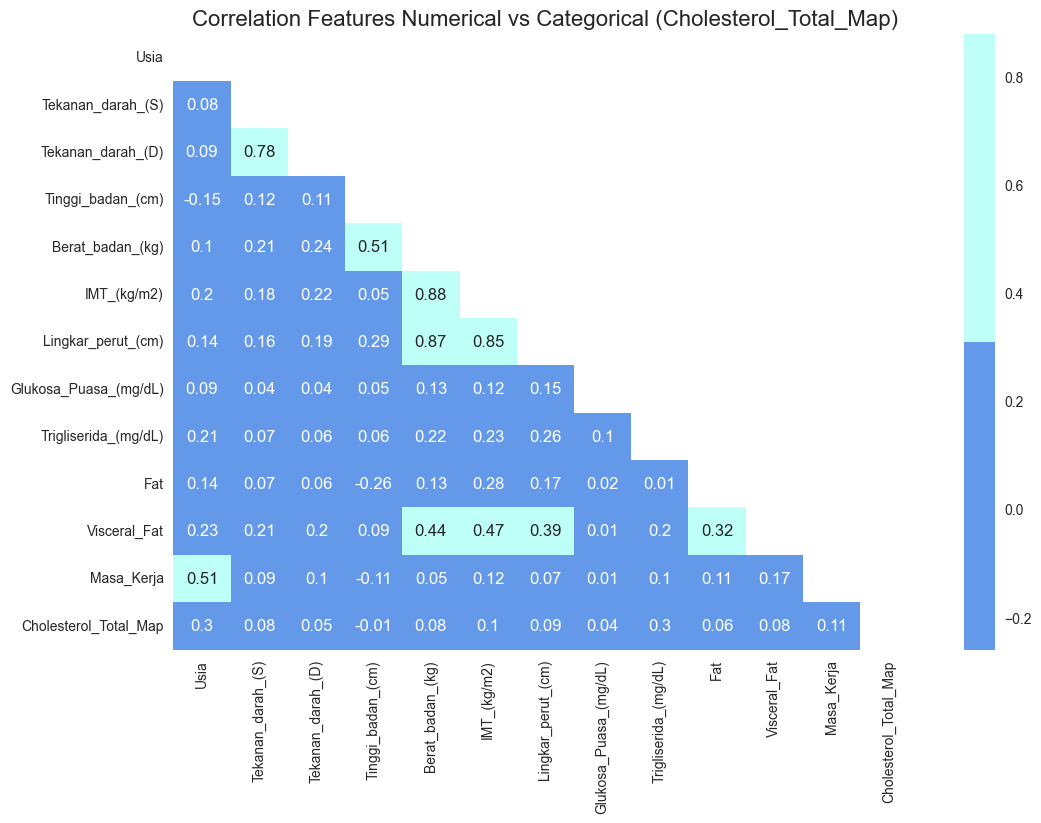

In [69]:
pbs_results = np.array(rows)
pb_df = pd.DataFrame(pbs_results, columns = df[num_cols].columns, index =df[num_cols].columns)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
sns.heatmap(pb_df, annot=True, mask=np.triu(pb_df), cmap=palette)
ax.grid(False)

ax.set_title('Correlation Features Numerical vs Categorical (Cholesterol_Total_Map)', fontsize=16)

plt.show()


Hasil dalam plot menunjukan semua korelasi menghasilkan nilai koefision positif dengan label cholesterol total yang telah dilakukan binning dan hanya tinggi badan yang mempunyai nilai negatif.

#### 1.3.3 Cholesterol Total(Numeric) vs Numeric Features

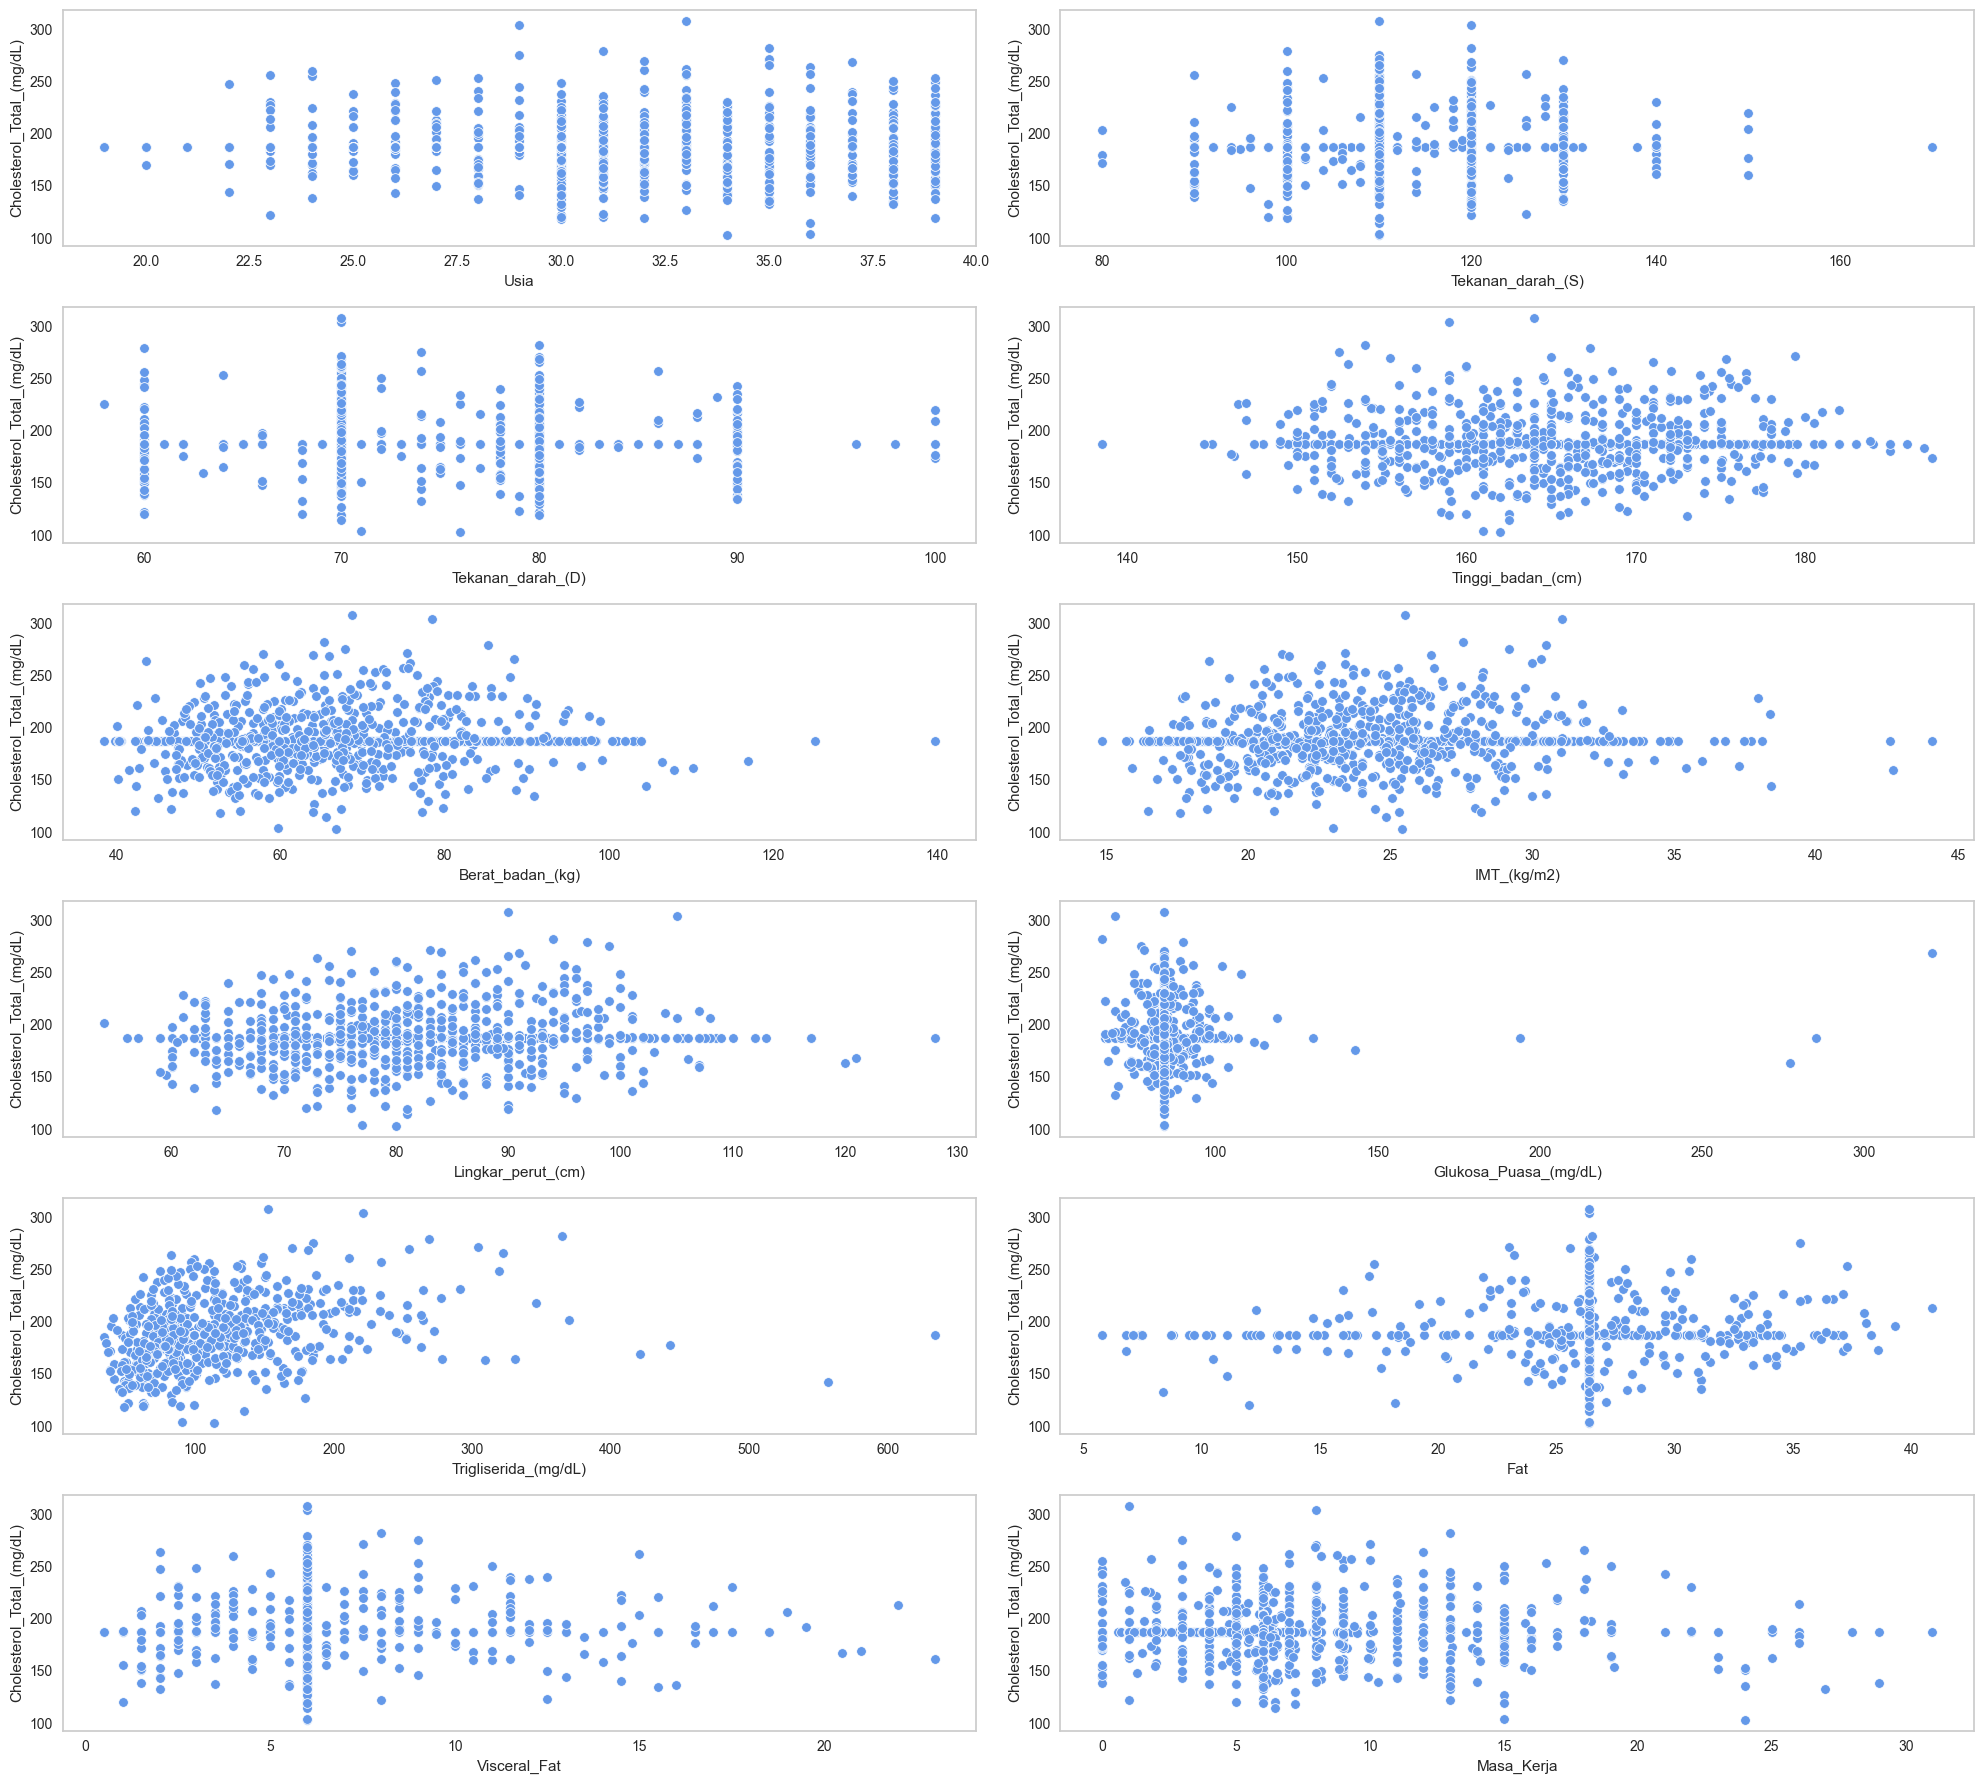

In [70]:
cols = [col for col in c.columns if c[col].dtype != 'object'][1:-4]
cols.remove('Cholesterol_Total_(mg/dL)')

f, ax = plt.subplots(6, 2, figsize=(20, 18))
for i, col in enumerate(cols):
    sns.scatterplot(data=df, x=df[col], y='Cholesterol_Total_(mg/dL)', ax=ax[i//2, i%2], color=palette[0])
    ax[i//2, i%2].grid(False)
    
plt.tight_layout()
plt.show()

#### 1.3.4 Correlation Analysis with Cramer's V Correlation

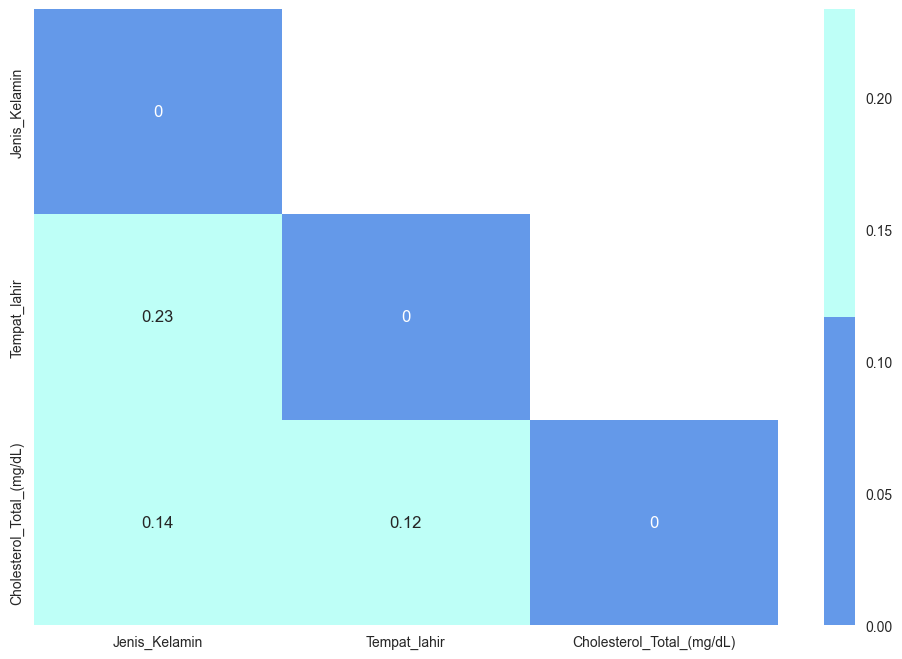

In [71]:
from scipy.stats import chi2_contingency

cat_cols = [col for col in df.columns if df[col].dtype == 'object'] + ['Cholesterol_Total_(mg/dL)']
cat_cols.remove('IMT_Category')

cramers_v_df = pd.DataFrame(0, index=cat_cols, columns=cat_cols)

for col1 in cat_cols:
    for col2 in cat_cols:
        if col1 != col2:
            contingency_table = pd.crosstab(df[col1], df[col2])
            if contingency_table.empty or (contingency_table.values == 0).all():
                cramers_v_df.loc[col1, col2] = 0
            else:
                chi2, _, _, _ = chi2_contingency(contingency_table)
                n = contingency_table.sum().sum()
                min_dim = min(contingency_table.shape) - 1
                cramers_v = (chi2 / n) / min_dim
                cramers_v_df.loc[col1, col2] = cramers_v



f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
sns.heatmap(cramers_v_df, annot=True, mask=np.triu(cramers_v_df), cmap=palette)
ax.grid(False)


## 2. **Feature Engineering** <a class="anchor" id="1.1"></a>

The following feature engineering steps were conducted:
- group the usia using kmeans
- create new columns Age_BP_ratio_interaction, Combined_Risk_Score

In [72]:
data = df.copy()
data.drop(['Responden', 'Tempat_lahir', 'Tinggi_badan (m)', 'IMT', 'Cholesterol_Total_Map','IMT_Category','IMT_gap'],axis=1,inplace=True)

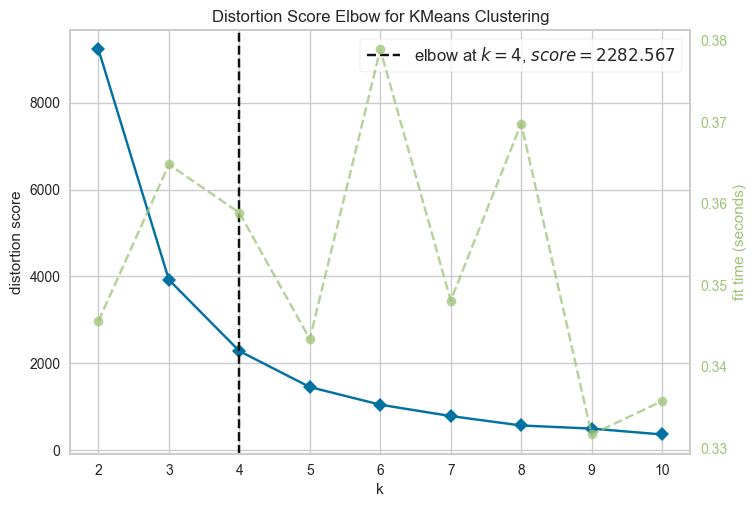

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [73]:
# perform elbow method to see the optimum cluster for usia in order to binning 
Elbow_M = KElbowVisualizer(KMeans(init='k-means++'), k=10)
Elbow_M.fit(data[['Usia']])
Elbow_M.show()

In [74]:
# binning usia with clustering
kmeans = KMeans(n_clusters=4,init='k-means++')
yhat_AC = kmeans.fit_predict(data[['Usia']])
data['usia_clusters'] = yhat_AC

In [75]:
#calculate age ratio with blood pressure
data['Age_BP_ratio_interaction'] = data['Usia'] * data['Tekanan_darah_(S)'] / data['Tekanan_darah_(D)']


weights = {'BMI': 0.4, 'Blood_Pressure': 0.3, 'Glucose_Level': 0.3}
# Calculate the combined risk score
data['Combined_Risk_Score'] = (weights['BMI'] * data['IMT_(kg/m2)'] +
                             weights['Blood_Pressure'] * (data['Tekanan_darah_(S)'] + data['Tekanan_darah_(D)']) / 2 +
                             weights['Glucose_Level'] * data['Glukosa_Puasa_(mg/dL)'])


In [76]:
data.drop(['Usia'], axis=1, inplace=True)

## 3. **Model Development** <a class="anchor" id="1.1"></a>

The following feature engineering steps were conducted:
- Perform transformation for the label using np.log1p
- Encode the gender feature
- Perform transformation for high skewed(>0.5) features 
- Perform polynomial to capture non linear relationship
- Utilize three models, lgbm, xgb, and cat with repeated kfold
- Select a model with the lowes mae for each iteration and fold
- Metrics used MAE and RMSE

In [77]:
# apply transformation since it is skewed as we saw in the eda phase
data['Cholesterol_Total_(mg/dL)'] = np.log1p(data['Cholesterol_Total_(mg/dL)'])

In [78]:
# apply labelencoder instead of onehotencoder to prevent overfitting since the data is small
label_encoder = LabelEncoder()

data['Gender'] = label_encoder.fit_transform(data['Jenis_Kelamin'])

data.drop(['Jenis_Kelamin'], axis=1, inplace=True)

In [79]:
y = data['Cholesterol_Total_(mg/dL)']
x = data.drop('Cholesterol_Total_(mg/dL)', axis=1)

In [80]:
#checking high skewed (> 0.5)
skew_check = x.apply(lambda x: abs(skew(x)))
skew_check = skew_check.reset_index(name='skew')
skewness = skew_check[skew_check['skew']>0.5]
skewed_feats = skewness['index'][:-1]
skewness

,index,skew
3,Berat_badan_(kg),0.926983
4,IMT_(kg/m2),0.835478
6,Glukosa_Puasa_(mg/dL),14.707050
7,Trigliserida_(mg/dL),4.346800
8,Fat,1.798487
9,Visceral_Fat,2.334119
10,Masa_Kerja,1.672822
12,Age_BP_ratio_interaction,0.645872
13,Combined_Risk_Score,5.808394
14,Gender,1.195482


In [81]:
# perform transformation to get as close as possible with normal distribution
for feature in skewed_feats:
    optimal_lambda = boxcox_normmax(x[feature] + 1)
    
    x[feature] = boxcox1p(x[feature], optimal_lambda)

In [82]:
# apply polynomial since the features are not very linear with the label, and set the degree to 2 to prevent overfitting
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(x)

In [83]:
# class Model with xgb and lgbm inside
# get the model with the lowest mae for each iteration and fold
class Model():
    def __init__(self, x, y, n_splits, repeated, rdm_seed, model, params):
        self.x =x
        self.y = y
        self.n_splits =n_splits
        self.repeated = repeated
        self.rdm_seed = rdm_seed
        self.model = model
        self.params = params
        self.cv_splitter = None
        self.best_model = None
        self.best_rmse = float('inf')
        
    def split_data(self):
        cv = RepeatedKFold(n_splits=self.n_splits, n_repeats=self.repeated, random_state=self.rdm_seed)
        for fold, (train_idx, val_idx) in enumerate(cv.split(self.x, self.y)):
            X_train = self.x[train_idx]
            X_val = self.x[val_idx]
            y_train = self.y[train_idx]
            y_val = self.y[val_idx]
            yield X_train, X_val, y_train, y_val
        
    def fit(self, key):
        if key == 'xgb':
            rmse_per_fold = []
            self.cv_splitter = self.split_data()
            
            for fold, (X_train, X_val, y_train, y_val) in enumerate(self.cv_splitter):
                model = self.model(**self.params)
                model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='rmse', early_stopping_rounds=100, verbose=False)
                eval_results = model.evals_result_
                val_rmse = eval_results['validation_0']['rmse'][-1]  
                
                if val_rmse < self.best_rmse:  
                    self.best_rmse = val_rmse
                    self.best_model = model
                
                print(f"FOLD {fold} | RMSE: {val_rmse:.5f}")
                rmse_per_fold.append(val_rmse)
            
            print(f"Average RMSE across all folds: {np.mean(rmse_per_fold):.5f}")
            
        elif key == 'lgb':
            rmse_per_fold = [] 
            self.cv_splitter = self.split_data()

            for fold, (X_train, X_val, y_train, y_val) in enumerate(self.cv_splitter):
                model = self.model(**self.params)
                model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='rmse')  
                eval_results = model.evals_result_
                val_rmse = eval_results['valid_0']['rmse'][-1]  

                if val_rmse < self.best_rmse:
                    self.best_rmse = val_rmse
                    self.best_model = model

                print(f"FOLD {fold} | RMSE: {val_rmse:.5f}")
                rmse_per_fold.append(val_rmse)

            print(f"Average RMSE across all folds: {np.mean(rmse_per_fold):.5f}")
            
        elif key == 'cat':
            rmse_per_fold = []  
            self.cv_splitter = self.split_data()
            
            for fold, (X_train, X_val, y_train, y_val) in enumerate(self.cv_splitter):
                model = self.model(**self.params, loss_function='RMSE')  
                model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
                eval_results = model.get_evals_result()
                
                val_rmse = eval_results['validation']['RMSE'][-1]  
                best_iteration = model.best_iteration_
                
                print(f"FOLD {fold} | RMSE: {val_rmse:.5f}")
                rmse_per_fold.append(val_rmse)
                
                if val_rmse < self.best_rmse:  
                    self.best_rmse = val_rmse
                    self.best_model = model

            print(f"Average RMSE across all folds: {np.mean(rmse_per_fold):.5f}")
            
    def predict(self):
        self.cv_splitter = self.split_data()
        all_rmse = []
        all_rmse_train = []
        for fold, (X_train, X_val, y_train, y_val) in enumerate(self.cv_splitter):
            X_train, X_val, y_train, y_val = X_train, X_val, y_train, y_val
    
            if self.best_model is None:
                raise ValueError("Model has not been trained yet. Call 'fit()' method first.")
            else: 
                y_preds = self.best_model.predict(X_val)
                rmse = np.sqrt(mean_squared_error(y_val, y_preds))
                all_rmse.append(rmse)
                
                train_preds = self.best_model.predict(X_train)
                train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
                all_rmse_train.append(train_rmse)
                print(f"FOLD {fold} | RMSE: {rmse:.5f}")
        avg_rmse = np.mean(all_rmse)
        avg_rmse_train = np.mean(all_rmse_train)
        print(f'Average RMSE Val: {avg_rmse} | Average RMSE Train: {avg_rmse_train}')
        return all_rmse, y_preds, y_val
    
    def feature_importance(self):
        feature_importances = self.best_model.feature_importances_
        n_original_features = len(x.columns)
        polynomial_feature_indices = np.arange(n_original_features, self.x.shape[1])
        polynomial_feature_names = [f"Poly_{i}" for i in polynomial_feature_indices]
        all_feature_names = list(x.columns) + polynomial_feature_names
        feature_importances_df = pd.DataFrame({'feature_weight': feature_importances}, index=all_feature_names)
        feature_importances_df = feature_importances_df.sort_values('feature_weight', ascending=False)
        return feature_importances_df
    
    def inverse(self, y_preds, y_val):
        y_preds = np.expm1(y_preds)
        y_val = np.expm1(y_val)
        return y_preds, y_val
    

In [84]:
cb_params = {'random_seed': 4897,  'verbose': False}
model_cat = Model(X_train_poly, y, 10, 3, 42, CatBoostRegressor, cb_params)

# Fit the model using RepeatedKFold
model_cat.fit('cat')
rmse, y_preds, y_val = model_cat.predict()

FOLD 0 | RMSE: 0.10413
FOLD 1 | RMSE: 0.10079
FOLD 2 | RMSE: 0.11027
FOLD 3 | RMSE: 0.10182
FOLD 4 | RMSE: 0.09134
FOLD 5 | RMSE: 0.11542
FOLD 6 | RMSE: 0.10335
FOLD 7 | RMSE: 0.12141
FOLD 8 | RMSE: 0.10766
FOLD 9 | RMSE: 0.12283
FOLD 10 | RMSE: 0.10135
FOLD 11 | RMSE: 0.10833
FOLD 12 | RMSE: 0.11547
FOLD 13 | RMSE: 0.10213
FOLD 14 | RMSE: 0.09896
FOLD 15 | RMSE: 0.09622
FOLD 16 | RMSE: 0.10082
FOLD 17 | RMSE: 0.09763
FOLD 18 | RMSE: 0.14310
FOLD 19 | RMSE: 0.10004
FOLD 20 | RMSE: 0.10781
FOLD 21 | RMSE: 0.09726
FOLD 22 | RMSE: 0.11102
FOLD 23 | RMSE: 0.09016
FOLD 24 | RMSE: 0.11535
FOLD 25 | RMSE: 0.11609
FOLD 26 | RMSE: 0.12503
FOLD 27 | RMSE: 0.10942
FOLD 28 | RMSE: 0.09799
FOLD 29 | RMSE: 0.09542
Average RMSE across all folds: 0.10696
FOLD 0 | RMSE: 0.02695
FOLD 1 | RMSE: 0.03858
FOLD 2 | RMSE: 0.03038
FOLD 3 | RMSE: 0.03545
FOLD 4 | RMSE: 0.04138
FOLD 5 | RMSE: 0.03188
FOLD 6 | RMSE: 0.03228
FOLD 7 | RMSE: 0.04247
FOLD 8 | RMSE: 0.02717
FOLD 9 | RMSE: 0.02226
FOLD 10 | RMSE: 0.032

In [85]:
params = {'random_state':42}


model_xgb = Model(X_train_poly, y, 10, 3, 42, XGBRegressor, params)

# Fit the model using RepeatedKFold
model_xgb.fit('xgb')
all_rmse, y_preds, y_val = model_xgb.predict()

FOLD 0 | RMSE: 0.11205
FOLD 1 | RMSE: 0.11138
FOLD 2 | RMSE: 0.12162
FOLD 3 | RMSE: 0.11213
FOLD 4 | RMSE: 0.09598
FOLD 5 | RMSE: 0.11531
FOLD 6 | RMSE: 0.10848
FOLD 7 | RMSE: 0.12173
FOLD 8 | RMSE: 0.11786
FOLD 9 | RMSE: 0.12955
FOLD 10 | RMSE: 0.11293
FOLD 11 | RMSE: 0.10813
FOLD 12 | RMSE: 0.11020
FOLD 13 | RMSE: 0.10773
FOLD 14 | RMSE: 0.10998
FOLD 15 | RMSE: 0.09981
FOLD 16 | RMSE: 0.11465
FOLD 17 | RMSE: 0.10440
FOLD 18 | RMSE: 0.15239
FOLD 19 | RMSE: 0.10803
FOLD 20 | RMSE: 0.11317
FOLD 21 | RMSE: 0.10935
FOLD 22 | RMSE: 0.10565
FOLD 23 | RMSE: 0.09344
FOLD 24 | RMSE: 0.13507
FOLD 25 | RMSE: 0.12278
FOLD 26 | RMSE: 0.12353
FOLD 27 | RMSE: 0.12600
FOLD 28 | RMSE: 0.10225
FOLD 29 | RMSE: 0.09271
Average RMSE across all folds: 0.11328
FOLD 0 | RMSE: 0.06344
FOLD 1 | RMSE: 0.05172
FOLD 2 | RMSE: 0.06327
FOLD 3 | RMSE: 0.05118
FOLD 4 | RMSE: 0.05411
FOLD 5 | RMSE: 0.04865
FOLD 6 | RMSE: 0.05726
FOLD 7 | RMSE: 0.05454
FOLD 8 | RMSE: 0.06327
FOLD 9 | RMSE: 0.06441
FOLD 10 | RMSE: 0.050

In [86]:
params = {'random_state':42,'verbosity':-1}
model_lgbm = Model(X_train_poly, y, 10, 3, 42, lgbm.LGBMRegressor, params)

# Fit the model using RepeatedKFold
model_lgbm.fit('lgb')
all_rmse_lgb, y_preds, y_val = model_lgbm.predict()

FOLD 0 | RMSE: 0.10594
FOLD 1 | RMSE: 0.10678
FOLD 2 | RMSE: 0.10723
FOLD 3 | RMSE: 0.10662
FOLD 4 | RMSE: 0.09834
FOLD 5 | RMSE: 0.10682
FOLD 6 | RMSE: 0.10379
FOLD 7 | RMSE: 0.12157
FOLD 8 | RMSE: 0.10769
FOLD 9 | RMSE: 0.13032
FOLD 10 | RMSE: 0.10398
FOLD 11 | RMSE: 0.11184
FOLD 12 | RMSE: 0.11270
FOLD 13 | RMSE: 0.10817
FOLD 14 | RMSE: 0.10361
FOLD 15 | RMSE: 0.09289
FOLD 16 | RMSE: 0.10224
FOLD 17 | RMSE: 0.09883
FOLD 18 | RMSE: 0.14831
FOLD 19 | RMSE: 0.10748
FOLD 20 | RMSE: 0.10568
FOLD 21 | RMSE: 0.10273
FOLD 22 | RMSE: 0.10635
FOLD 23 | RMSE: 0.09198
FOLD 24 | RMSE: 0.11908
FOLD 25 | RMSE: 0.11767
FOLD 26 | RMSE: 0.12742
FOLD 27 | RMSE: 0.11231
FOLD 28 | RMSE: 0.09858
FOLD 29 | RMSE: 0.10127
Average RMSE across all folds: 0.10894
FOLD 0 | RMSE: 0.02916
FOLD 1 | RMSE: 0.04016
FOLD 2 | RMSE: 0.03558
FOLD 3 | RMSE: 0.04298
FOLD 4 | RMSE: 0.03907
FOLD 5 | RMSE: 0.03677
FOLD 6 | RMSE: 0.03422
FOLD 7 | RMSE: 0.04727
FOLD 8 | RMSE: 0.03275
FOLD 9 | RMSE: 0.02736
FOLD 10 | RMSE: 0.037

##### Tunning

In [87]:
TUNE_MODEL = False

In [88]:
def objective(trial, x, y, n_splits, repeated, rdm_seed):
    # Define the search space for hyperparameters
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
        'n_estimators': 5000,
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 8),
        'device_type': 'cpu',
        'num_leaves': trial.suggest_int('num_leaves', 4, 2048),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "verbosity": -1,
        "early_stopping_rounds": 50,
    }
    
    # Create and train the model using the suggested hyperparameters
    model = lgbm.LGBMRegressor(**params)
    rmse_per_fold = []
    cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeated, random_state=rdm_seed)
    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_poly, y)):
        X_train = x.iloc[train_idx]
        X_val = x.iloc[val_idx]
        y_train = y.iloc[train_idx]
        y_val = y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        train_pred = model.predict(X_train)
        rmse_train = np.sqrt(mean_squared_error(y_train, train_pred))
        rmse_per_fold.append(rmse)
    print(f'rmse val: {np.mean(rmse)} | train rmse {np.mean(rmse_train)}')
    # Return the mean MAE across all folds as the objective value
    return np.mean(rmse_per_fold)

if TUNE_MODEL:
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, x, y, 10, 3, 42), n_trials=500)

    # Get best hyperparameters
    best_params = study.best_params

In [114]:
params = {'learning_rate': 0.007353634265704398, 
          'verbosity':-1,
          'lambda_l1': 3.664181138122969e-05, 
          'lambda_l2': 0.397498474634019,
          'max_depth': 15, 
          'colsample_bytree': 0.6671155956864336, 
          'subsample': 0.6455796395952734, 
          'seed':0,
          'n_estimators':3000,
          'min_child_weight': 1, 
          'num_leaves': 998, 
          'min_child_samples': 11}
model_lgbm_tune = Model(X_train_poly, y, 10, 3, 42, lgbm.LGBMRegressor, params)

model_lgbm_tune.fit('lgb')
all_rmse_tune_lgb,y_preds, y_val = model_lgbm_tune.predict()
feature_importances_lgb = model_lgbm_tune.feature_importance()
y_preds_inverse_lgb , y_val_inverse_lgb = model_lgbm_tune.inverse(y_preds, y_val)

FOLD 0 | RMSE: 0.10873
FOLD 1 | RMSE: 0.10242
FOLD 2 | RMSE: 0.10619
FOLD 3 | RMSE: 0.10027
FOLD 4 | RMSE: 0.09317
FOLD 5 | RMSE: 0.10839
FOLD 6 | RMSE: 0.10471
FOLD 7 | RMSE: 0.12401
FOLD 8 | RMSE: 0.10746
FOLD 9 | RMSE: 0.12632
FOLD 10 | RMSE: 0.10352
FOLD 11 | RMSE: 0.10928
FOLD 12 | RMSE: 0.11363
FOLD 13 | RMSE: 0.10798
FOLD 14 | RMSE: 0.10228
FOLD 15 | RMSE: 0.08925
FOLD 16 | RMSE: 0.09908
FOLD 17 | RMSE: 0.10274
FOLD 18 | RMSE: 0.14473
FOLD 19 | RMSE: 0.10868
FOLD 20 | RMSE: 0.10512
FOLD 21 | RMSE: 0.10058
FOLD 22 | RMSE: 0.10348
FOLD 23 | RMSE: 0.09013
FOLD 24 | RMSE: 0.11575
FOLD 25 | RMSE: 0.11811
FOLD 26 | RMSE: 0.12766
FOLD 27 | RMSE: 0.10678
FOLD 28 | RMSE: 0.10258
FOLD 29 | RMSE: 0.10340
Average RMSE across all folds: 0.10788
FOLD 0 | RMSE: 0.04424
FOLD 1 | RMSE: 0.02704
FOLD 2 | RMSE: 0.02905
FOLD 3 | RMSE: 0.02799
FOLD 4 | RMSE: 0.01096
FOLD 5 | RMSE: 0.02527
FOLD 6 | RMSE: 0.02635
FOLD 7 | RMSE: 0.03377
FOLD 8 | RMSE: 0.02073
FOLD 9 | RMSE: 0.03003
FOLD 10 | RMSE: 0.005

In [90]:
def objective(trial, x, y, n_splits, repeated, rdm_seed):
    # Define the search space for hyperparameters
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 5000),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20)
    }
    
    # Create and train the model using the suggested hyperparameters
    model = XGBRegressor(**params)
    rmse_per_fold = []
    cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeated, random_state=rdm_seed)
    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_poly, y)):
        X_train = x.iloc[train_idx]
        X_val = x.iloc[val_idx]
        y_train = y.iloc[train_idx]
        y_val = y.iloc[val_idx]
        
        model.fit(X_train, y_train, verbose=False)
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        train_pred = model.predict(X_train)
        rmse_train = np.sqrt(mean_squared_error(y_train, train_pred))
        
        rmse_per_fold.append(rmse)
    print(f'rmse val: {np.mean(rmse)} | train rmse {np.mean(rmse_train)}')
    # Return the mean MAE across all folds as the objective value
    return np.mean(rmse_per_fold)

if TUNE_MODEL:
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, x, y, 5, 3, 42), n_trials=200)

    # Get best hyperparameters
    best_params = study.best_params

In [91]:
params_xgb_tune = {
 'learning_rate': 0.008770972905815029, 'gamma': 0.010389766652732217,  'n_estimators': 5000,
 'subsample': 0.947060544440863, 'colsample_bytree': 0.5322880680354992, 'max_depth': 15, 'min_child_weight': 1,
 'lambda': 0.016447721598348113, 'alpha': 0.008150293514577826, }

model_xgb_tune = Model(X_train_poly, y, 10, 3, 42, XGBRegressor, params_xgb_tune)

model_xgb_tune.fit('xgb')
all_rmse_tune_xgb, y_preds, y_val = model_xgb_tune.predict()
feature_importances_xgb = model_xgb_tune.feature_importance()
y_preds_inverse_xgb, y_val_inverse_xgb = model_xgb_tune.inverse(y_preds, y_val)

FOLD 0 | RMSE: 0.10338
FOLD 1 | RMSE: 0.09653
FOLD 2 | RMSE: 0.10458
FOLD 3 | RMSE: 0.09965
FOLD 4 | RMSE: 0.08997
FOLD 5 | RMSE: 0.11114
FOLD 6 | RMSE: 0.10475
FOLD 7 | RMSE: 0.11637
FOLD 8 | RMSE: 0.10425
FOLD 9 | RMSE: 0.12184
FOLD 10 | RMSE: 0.10232
FOLD 11 | RMSE: 0.10680
FOLD 12 | RMSE: 0.11152
FOLD 13 | RMSE: 0.10512
FOLD 14 | RMSE: 0.09863
FOLD 15 | RMSE: 0.09505
FOLD 16 | RMSE: 0.09695
FOLD 17 | RMSE: 0.10123
FOLD 18 | RMSE: 0.14534
FOLD 19 | RMSE: 0.10336
FOLD 20 | RMSE: 0.10731
FOLD 21 | RMSE: 0.09675
FOLD 22 | RMSE: 0.10066
FOLD 23 | RMSE: 0.09113
FOLD 24 | RMSE: 0.11735
FOLD 25 | RMSE: 0.11653
FOLD 26 | RMSE: 0.12604
FOLD 27 | RMSE: 0.10464
FOLD 28 | RMSE: 0.09741
FOLD 29 | RMSE: 0.09417
Average RMSE across all folds: 0.10569
FOLD 0 | RMSE: 0.02621
FOLD 1 | RMSE: 0.02653
FOLD 2 | RMSE: 0.02751
FOLD 3 | RMSE: 0.02748
FOLD 4 | RMSE: 0.08971
FOLD 5 | RMSE: 0.02462
FOLD 6 | RMSE: 0.02636
FOLD 7 | RMSE: 0.02709
FOLD 8 | RMSE: 0.02811
FOLD 9 | RMSE: 0.03234
FOLD 10 | RMSE: 0.037

In [92]:
def objective(trial, x, y, n_splits, repeated, rdm_seed):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 5000), 
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.9),
        'depth': trial.suggest_int('depth', 1, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.01, 10.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
         'random_seed': trial.suggest_int('random_seed', 1, 10000),
        'verbose': False,
       
    }
    
    model = CatBoostRegressor(**params)
    rmse_per_fold = []
    cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeated, random_state=rdm_seed)
    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_poly, y)):
        X_train = x.iloc[train_idx]
        X_val = x.iloc[val_idx]
        y_train = y.iloc[train_idx]
        y_val = y.iloc[val_idx]
        
        model.fit(X_train, y_train, verbose=False)
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        train_pred = model.predict(X_train)
        rmse_train = np.sqrt(mean_squared_error(y_train, train_pred))
        
        rmse_per_fold.append(rmse)
    print(f'rmse val: {np.mean(rmse)} | train rmse {np.mean(rmse_train)}')
    # Return the mean MAE across all folds as the objective value
    return np.mean(rmse_per_fold)

if TUNE_MODEL:
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, x, y, 5, 3, 42), n_trials=200)

    # Get best hyperparameters
    best_params = study.best_params

In [93]:
cb_params = {
     'learning_rate': 0.13762007048684638,
    'depth': 5, 
    'l2_leaf_reg': 5.285199432056192,
    'bagging_temperature': 0.6029582154263095,
    'random_seed': 42,
    'verbose': False,
    'iterations':1000,
}

model_cat = Model(X_train_poly, y, 10, 3, 42, CatBoostRegressor, cb_params)

model_cat.fit('cat')
all_rmse_cat, y_preds, y_val = model_cat.predict()
y_preds_inverse_cat, y_val_inverse_cat = model_cat.inverse(y_preds, y_val)

FOLD 0 | RMSE: 0.10600
FOLD 1 | RMSE: 0.10146
FOLD 2 | RMSE: 0.11887
FOLD 3 | RMSE: 0.10476
FOLD 4 | RMSE: 0.09724
FOLD 5 | RMSE: 0.11857
FOLD 6 | RMSE: 0.10666
FOLD 7 | RMSE: 0.12013
FOLD 8 | RMSE: 0.10622
FOLD 9 | RMSE: 0.12803
FOLD 10 | RMSE: 0.10628
FOLD 11 | RMSE: 0.11039
FOLD 12 | RMSE: 0.11275
FOLD 13 | RMSE: 0.10991
FOLD 14 | RMSE: 0.10526
FOLD 15 | RMSE: 0.10435
FOLD 16 | RMSE: 0.10124
FOLD 17 | RMSE: 0.10241
FOLD 18 | RMSE: 0.14049
FOLD 19 | RMSE: 0.10247
FOLD 20 | RMSE: 0.11359
FOLD 21 | RMSE: 0.10312
FOLD 22 | RMSE: 0.11012
FOLD 23 | RMSE: 0.08860
FOLD 24 | RMSE: 0.12204
FOLD 25 | RMSE: 0.12359
FOLD 26 | RMSE: 0.12665
FOLD 27 | RMSE: 0.11289
FOLD 28 | RMSE: 0.10059
FOLD 29 | RMSE: 0.09890
Average RMSE across all folds: 0.11012
FOLD 0 | RMSE: 0.03048
FOLD 1 | RMSE: 0.04359
FOLD 2 | RMSE: 0.03073
FOLD 3 | RMSE: 0.03838
FOLD 4 | RMSE: 0.04227
FOLD 5 | RMSE: 0.03176
FOLD 6 | RMSE: 0.03356
FOLD 7 | RMSE: 0.04777
FOLD 8 | RMSE: 0.03146
FOLD 9 | RMSE: 0.02928
FOLD 10 | RMSE: 0.033

### Proportion Splitting Data in the RepeatedKfold

In [99]:
num_folds = 10
num_repeats = 3

rkf = RepeatedKFold(n_splits=num_folds, n_repeats=num_repeats)

for fold, (train_index, val_index) in enumerate(rkf.split(X_train_poly)):
    total_samples = len(train_index) + len(val_index)
    
    train_samples = len(train_index)
    val_samples = len(val_index)
    
    train_percentage = (train_samples / total_samples) * 100
    validation_percentage = (val_samples / total_samples) * 100
    
    print(f"Fold {fold + 1}:")
    print(f"Percentage of data used for training: {train_percentage:.2f}%")
    print(f"Percentage of data used for validation: {validation_percentage:.2f}%")

Fold 1:
Percentage of data used for training: 89.99%
Percentage of data used for validation: 10.01%
Fold 2:
Percentage of data used for training: 89.99%
Percentage of data used for validation: 10.01%
Fold 3:
Percentage of data used for training: 89.99%
Percentage of data used for validation: 10.01%
Fold 4:
Percentage of data used for training: 89.99%
Percentage of data used for validation: 10.01%
Fold 5:
Percentage of data used for training: 89.99%
Percentage of data used for validation: 10.01%
Fold 6:
Percentage of data used for training: 89.99%
Percentage of data used for validation: 10.01%
Fold 7:
Percentage of data used for training: 89.99%
Percentage of data used for validation: 10.01%
Fold 8:
Percentage of data used for training: 89.99%
Percentage of data used for validation: 10.01%
Fold 9:
Percentage of data used for training: 89.99%
Percentage of data used for validation: 10.01%
Fold 10:
Percentage of data used for training: 90.07%
Percentage of data used for validation: 9.93%


## 4. **Interpret Feature Importances** <a class="anchor" id="1.1"></a>


When we compared XGBoost (xgb), LightGBM (lgbm) models and Catboost(cat) and fine-tuned them, we found that LGB performed slightly better. So, it's a good idea to focus on understanding which features are most important in the LGB model rather than the XGB and Cat model.

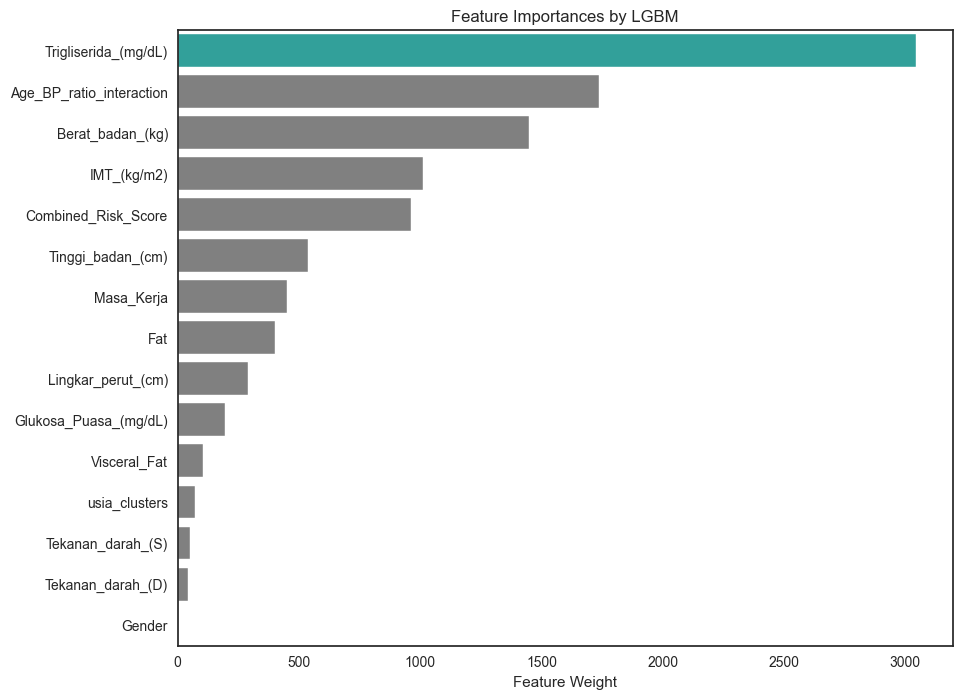

In [116]:
a = feature_importances_lgb.reset_index()
feature_importances_lgb = a[a['index'].isin(x.columns)]

feature_importances_lgb_filtered = feature_importances_lgb[feature_importances_lgb['index'].isin(x.columns)]
feature_importances_lgb_filtered_sorted = feature_importances_lgb_filtered.sort_values(by='feature_weight', ascending=False)

colors = ['lightseagreen'] + ['gray'] * (len(feature_importances_lgb_filtered_sorted) - 2) + ['lightsalmon']


plt.figure(figsize=(10, 8))
ax = sns.barplot(x='feature_weight', y='index', data=feature_importances_lgb_filtered_sorted, palette=colors)
ax.grid(False)

plt.title('Feature Importances by LGBM')
plt.xlabel('Feature Weight')
plt.ylabel('')

plt.show()

After examining the plot, our earlier analysis linking Triglycerides with total cholesterol is confirmed: Triglycerides hold the highest importance among the features. Additionally, Age BP ratio interaction (new feature) is the second rank, followed by Berat Badan. 

In summary, the top five features, from most to least important, are:
- Triglycerides
- Age BP ratio interaction
- Berat badan
- IMT
- Combined risk score

In [96]:
pred_val = pd.DataFrame(y_preds_inverse_lgb, columns=['predicted'])
pred_val['y_val'] = y_val_inverse_lgb.values
pred_val

,predicted,y_val
0,186.882364,187.0
1,186.820795,187.0
2,186.999030,187.0
3,187.091834,187.0
4,187.675212,187.0
...,...,...
128,134.267910,134.0
129,160.052902,160.0
130,219.410687,220.0
131,186.943011,187.0


The model demonstrates promising performance, achieving a root mean square error (RMSE) 0.02. This suggests that, on average, the model's predictions deviate from the actual values by a relatively small margin. Further analysis, such as visualizing the predicted values against the true labels, will provide deeper insights into the model's effectiveness.

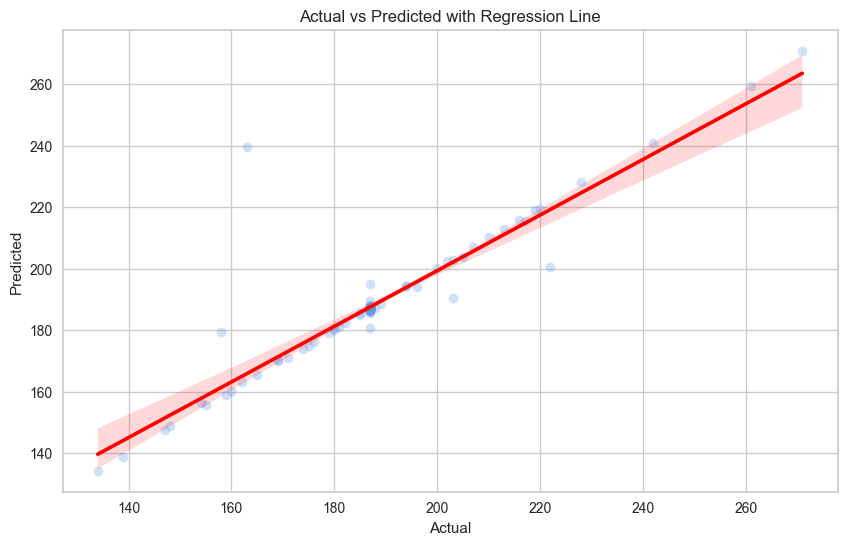

In [97]:
plt.figure(figsize=(10, 6))
color = palette[0]
sns.regplot(data=pred_val, x='y_val', y='predicted',  scatter_kws={"color": color, 'alpha': 0.3}, line_kws={"color": "red"})
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted with Regression Line')
plt.grid(True)
plt.show()

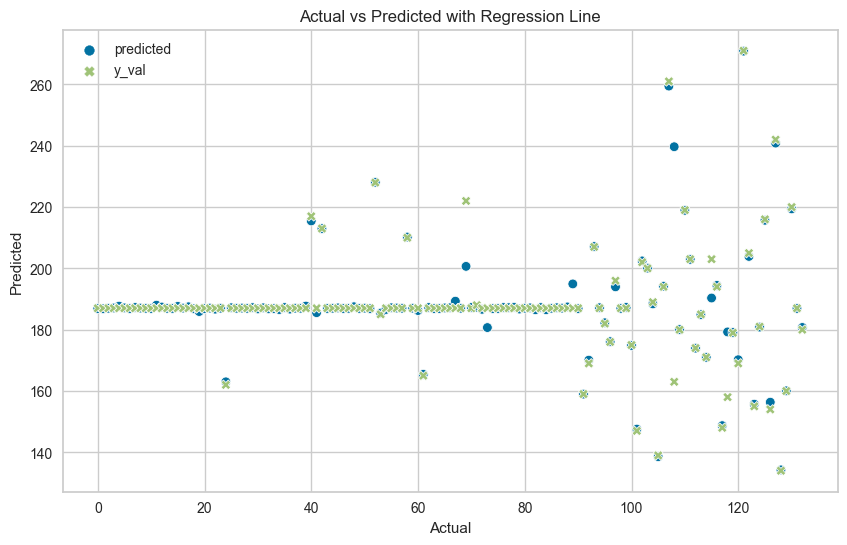

In [98]:
plt.figure(figsize=(10, 6))
sns.scatterplot(pred_val)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted with Regression Line')
plt.grid(True)
plt.show()

The data points mostly align with the regression line, showing that the model is good at predicting total cholesterol levels. While there are a few data point that a bit far away from the line, the predictions are still accurate.